# CS422 Data Mining

## Final Project

#### Christopher W. Hong

## Abstract

One of the most challenging aspects of Data Science workflow is building a data pipeline to automate the data workflow. In this project, I implement a data pipeline that extracts a `csv.` file from local disk, transforms it through data imputation, standardardization and PCA dimensionality reduction and feed it into a `Multinomial LogisticRegression` model. The aforementioned pipeline is converted into an ONNX based model that could fit and predict incoming data. My future work would put involve putting the model into deployment and production.

## Overview

In this project, I try to solve a singl-label, multiclass supervised maching learning classfication problem. The project is divided into the following steps:

* [Step 1](#step1): Load the Data
* [Step 2](#step2): Data Analysis
* [Step 3](#step3): Data Preprocessing
* [Step 4](#step4): Model Training
* [Step 5](#step5): Data Pipeline and ONNX Model

Part of my work is reference to Tan et, al.'s textbook Introduciton To Data Mining. Some of the couse code is reference to Udatic.com Introduction to Machine Learning program.

Final deliverables of this project:

* A **Scikit-Learn** based **Pipeline**, `Scikit_Learn_public_pipeline.pmml`, for training with the provided datain csv format
* A **ONNX** based **Model**, `ONNX_public_pipeline.onnx`, for testing with a runntie session in onnx format
* A **ONNX** based **Model** computation graph, `ONNX_public_pipeline.dot.png`, for displaying the workflow of the proejct

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

import onnxruntime as rt

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

import graphviz

import os
import time

<a id='step1'></a>
## Step 1: Load the Data

- In this project, there is only one `.csv` file, `data_public.csv`. The data set is well formatted with headers on the first row and values afterwards. To start off with, the dataset is loaded into a pandas DataFrame. Then, it is splitted into train and test set, respectively.

In [2]:
def load_data(test_size=0.25):
    data_path = 'data_public.csv'
    data = pd.read_csv(data_path)
    
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], 
                                                        data.iloc[:,-1], 
                                                        test_size=test_size,
                                                        shuffle=True,
                                                        stratify=data.iloc[:,-1],
                                                        random_state=0)
    
    return X_train, X_test, y_train, y_test                                                   

In [3]:
X_train, X_test, y_train, y_test  = load_data()

<a id='step2'></a>
## Step 2: Exploratory Data Analysis

- The dataset contains total of 1.2 million samples that is splitted into train set (900,000 sampels) and test set (300,000 sampels) (see **[2.1](#2.1)**). 

- There are 15 interval attributes (i.e. A, B, C, ..., M, N, O) and 1 nominal target variable (Class). Based on the five summary statistics, each attribute is on different scale (see **[2.2-2.4](#2.2)**). There are no missing values found (see **[2.5](#2.5)**). 

- By plotting every attribute using histogram (see **[2.6.1](#2.6.1)**):
    - attribute L is roughly symmetric and single-peaked normally distributed with mean -2.56 and standard deviation 3.26 
    - attributes C, F, M, N and O are symmetric and double-peaked normally distributed
    - attributes A, D, E, H and I are symmetric and triple-peaked normally distributed
    - attributes B, G, J and K are double-peaked but far away from normally distributed
    
- The Class variable cotains the nonimal categories (**[2.6.2](#2.6.2)**):
    - 1 (roungly 16%)
    - 2 (roughly 50%)
    - 3 (roughly 30%)
    
- Most attributes are strongly correlated with each other (see **[2.7](#2.7)**):
    - Correlation of attribute A with attributes: 
    
        - H    0.969381
        - E    0.948110
        - F    0.947113
        - G    0.942607
        - K    0.937922
        - C    0.936640
        - N    0.878303
        - O    0.834547
        - M    0.810431
        
    - There is almost no correlations between L and H, N and J and O and J

<a id='2.1'></a>
### Step 2.1: Shape

In [4]:
X_train.shape, X_test.shape

((900000, 15), (300000, 15))

<a id='2.2'></a>
### Step 2.2: Overview

In [5]:
X_train.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
743422,30.694301,-4.510013,32.629415,-4.426302,15.107931,8.199783,14.697538,28.873657,9.155283,21.947404,34.721002,-3.878734,-4.823854,17.947639,18.413306
383146,30.571704,-7.348726,31.739618,-3.942466,17.735029,16.615125,15.039462,22.910014,13.120900,15.914758,28.704920,-6.766428,-7.603983,25.201001,20.121344
571927,-22.529121,-16.797825,-1.518253,6.028138,-17.387987,-16.663047,-2.276736,-14.742913,-6.902447,4.930861,-0.758564,0.415491,-29.221419,-4.247463,-7.940310
775988,-22.577204,-13.181493,3.803832,3.829021,-18.089498,-16.876560,-2.592021,-16.559014,-11.980381,8.345481,-2.993991,-8.151327,-33.919467,-7.571207,-3.099103
1135094,-22.855145,-14.185247,-1.009096,5.403067,-20.526347,-16.287054,-1.322732,-17.308591,-6.920394,8.757701,-0.057821,-2.957642,-32.225796,-10.347218,-5.394380


### Step 2.3: Attribute Info

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 743422 to 300622
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   A       900000 non-null  float64
 1   B       900000 non-null  float64
 2   C       900000 non-null  float64
 3   D       900000 non-null  float64
 4   E       900000 non-null  float64
 5   F       900000 non-null  float64
 6   G       900000 non-null  float64
 7   H       900000 non-null  float64
 8   I       900000 non-null  float64
 9   J       900000 non-null  float64
 10  K       900000 non-null  float64
 11  L       900000 non-null  float64
 12  M       900000 non-null  float64
 13  N       900000 non-null  float64
 14  O       900000 non-null  float64
dtypes: float64(15)
memory usage: 109.9 MB


### Step 2.4: Summary Statistics

In [7]:
X_train.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
count,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,-0.564278,-7.431878,10.691968,-1.299514,-1.716432,-8.376503,2.565140,1.248010,2.309453,8.033025,10.970160,-2.568638,-18.174802,4.713074,7.750840
std,24.347478,5.357942,13.919688,6.855692,15.938334,13.298858,9.717093,20.503575,11.825044,9.120251,15.403352,3.266472,14.602226,13.546956,12.858806
min,-36.580247,-24.830244,-13.295041,-23.654167,-27.038437,-32.053126,-17.825976,-29.578916,-16.286628,-17.136276,-15.507032,-15.385477,-39.592672,-17.882749,-14.104568
25%,-21.908113,-11.994454,0.313338,-5.221361,-17.178513,-18.474004,-5.016508,-18.151284,-8.798607,4.664434,-3.787524,-4.816144,-32.540704,-8.565352,-4.914453
50%,-6.036425,-6.839075,2.906377,-2.680716,1.962505,-15.267704,-1.503992,1.590343,1.568750,8.908654,10.436519,-2.918777,-13.481601,7.434967,11.814006
75%,30.310010,-3.648582,27.779787,4.775479,15.811770,7.626976,12.976652,24.735030,11.529269,14.750203,26.401167,-0.610715,-4.139969,17.948127,20.481521
max,46.096031,15.067007,44.756654,14.026615,27.076708,24.893380,32.682561,40.757517,30.832548,32.262070,46.046872,12.238276,11.634766,32.011432,31.838291


<a id='2.5'></a>
### Step 2.5: Null Check

In [8]:
X_train.isnull().sum(), X_test.isnull().sum()

(A    0
 B    0
 C    0
 D    0
 E    0
 F    0
 G    0
 H    0
 I    0
 J    0
 K    0
 L    0
 M    0
 N    0
 O    0
 dtype: int64,
 A    0
 B    0
 C    0
 D    0
 E    0
 F    0
 G    0
 H    0
 I    0
 J    0
 K    0
 L    0
 M    0
 N    0
 O    0
 dtype: int64)

### Step 2.6: Visualization

<a id='2.6.1'></a>
#### Step 2.6.1: Feature Distribution

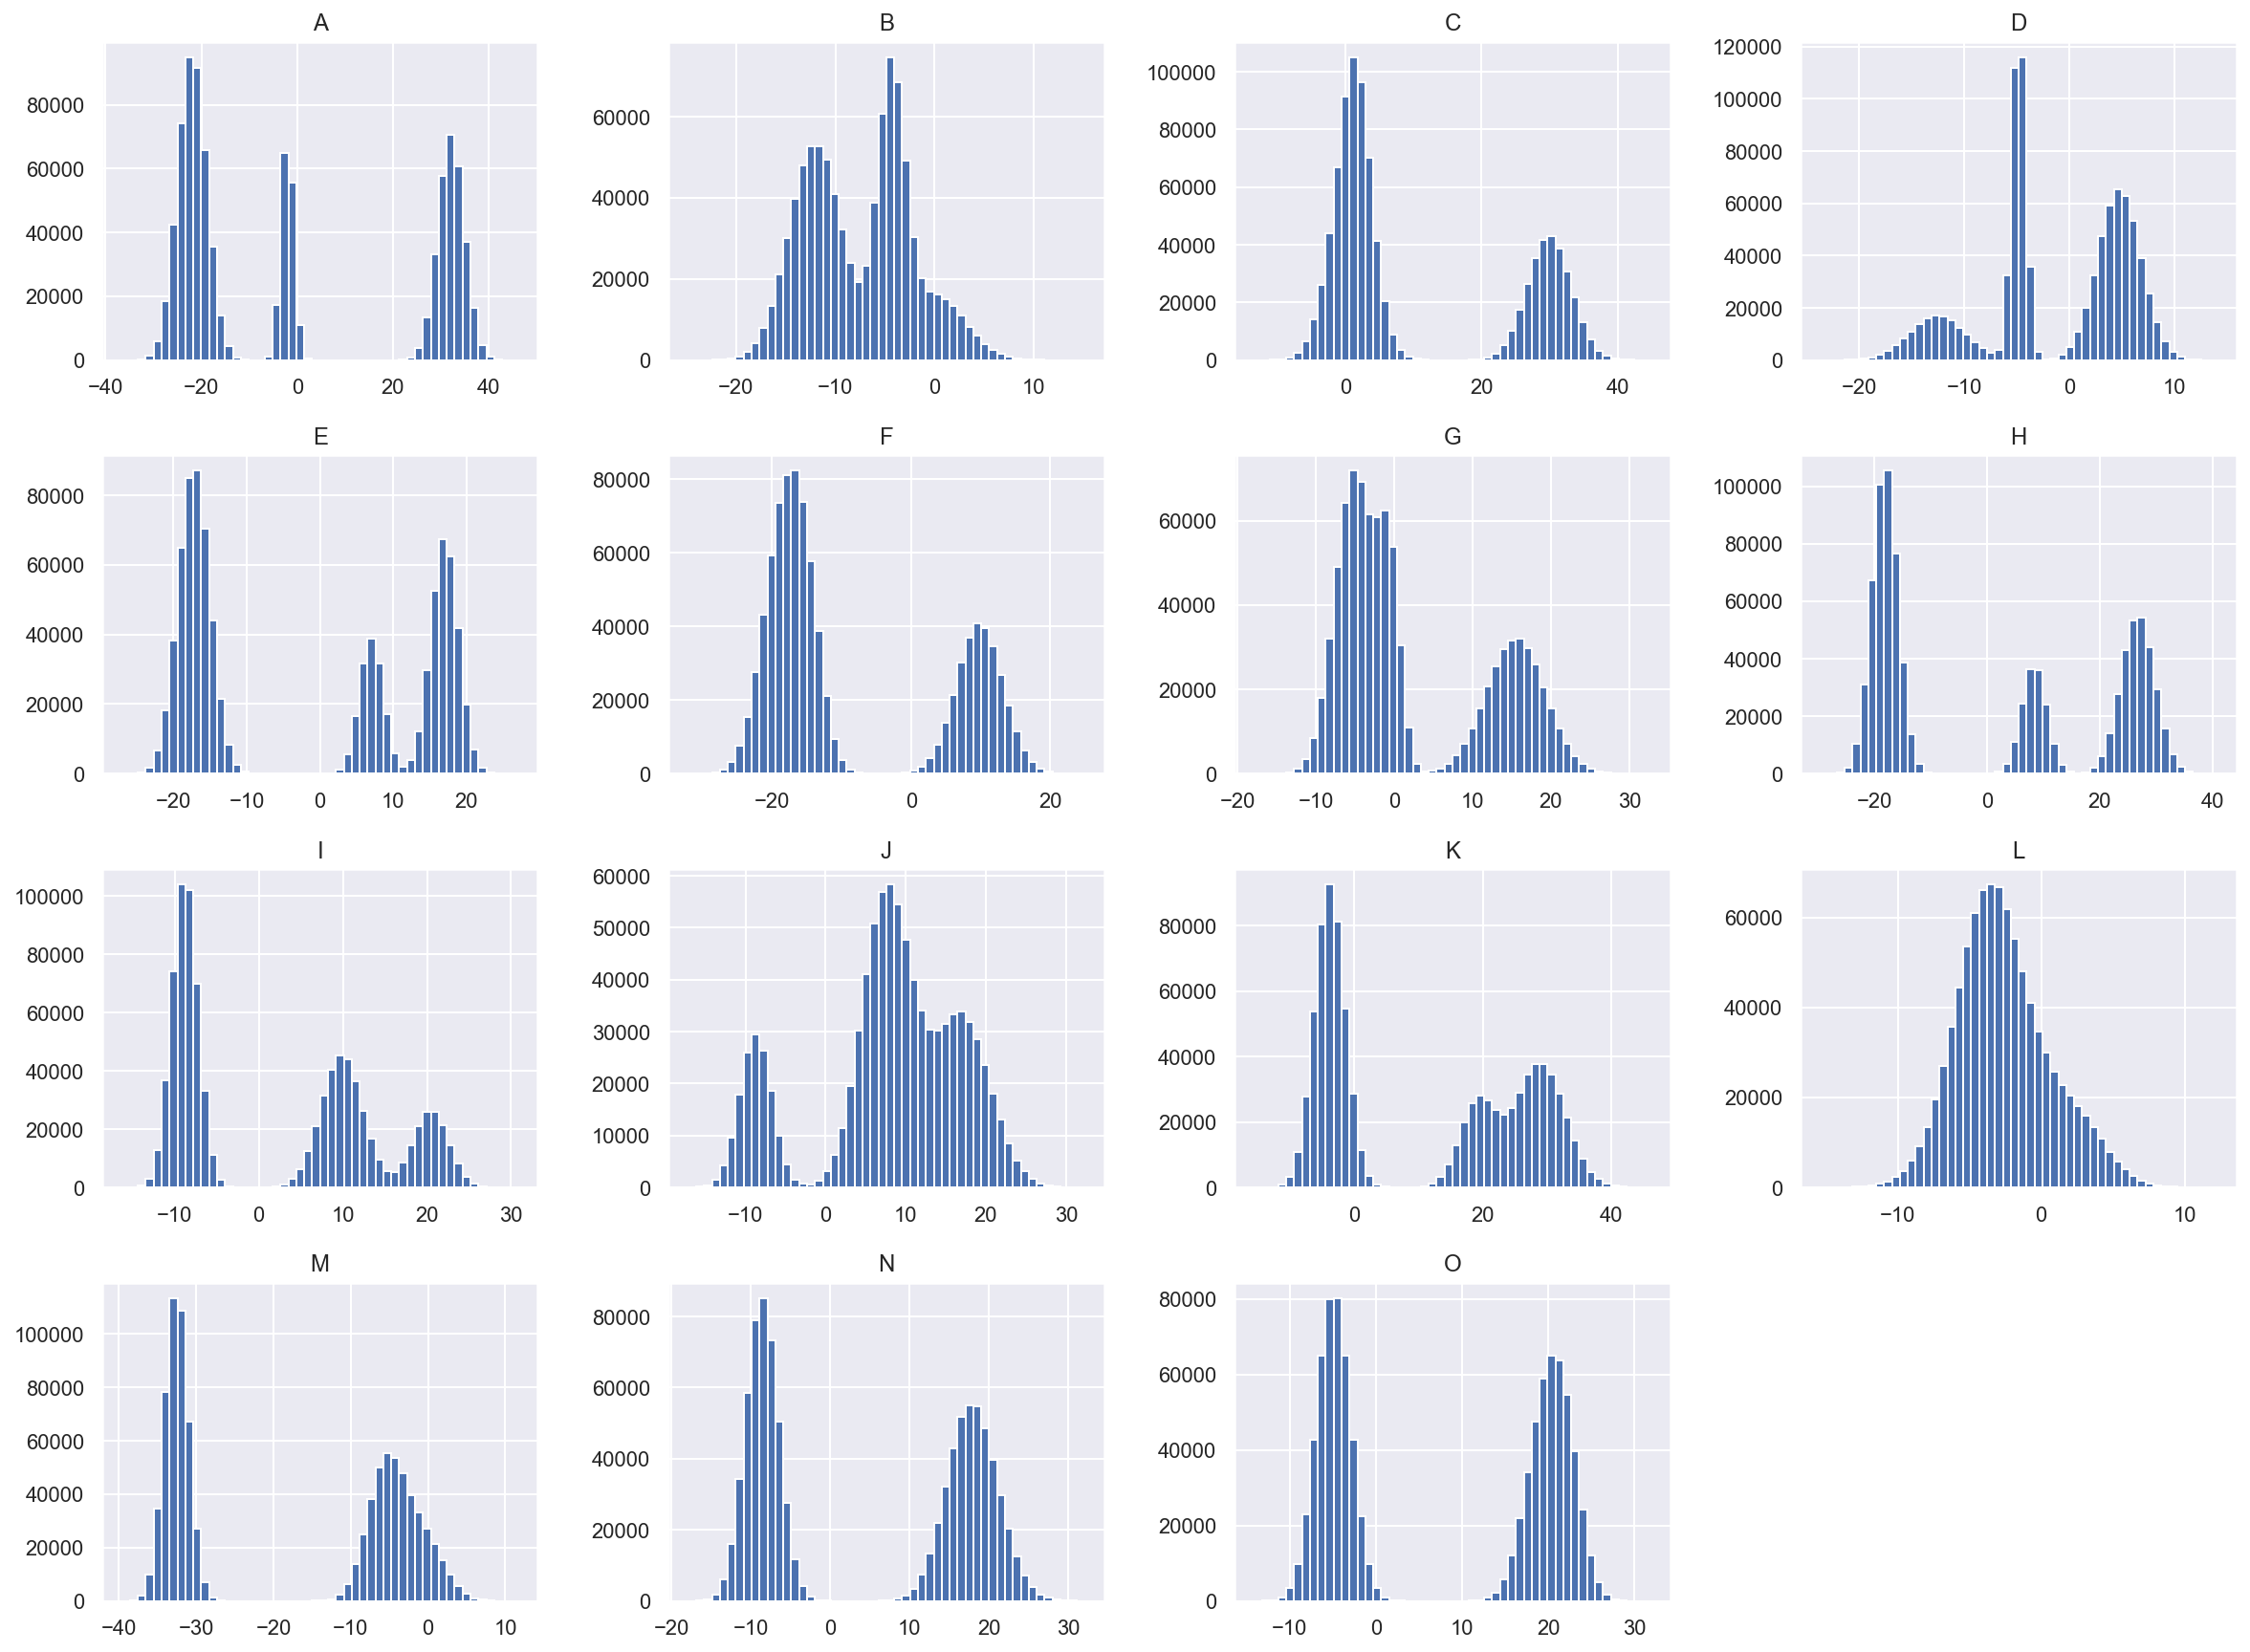

In [9]:
X_train.hist(bins=50, figsize=(20,15))
plt.show();

<a id='2.6.2'></a>
#### Step 2.6.2: Class Distribution

In [10]:
df_y = pd.DataFrame({'train': y_train.value_counts()/ len(y_train), 'test': y_test.value_counts() / len(y_test)})

In [11]:
df_y

,train,test
2,0.499859,0.499860
3,0.333389,0.333387
1,0.166752,0.166753


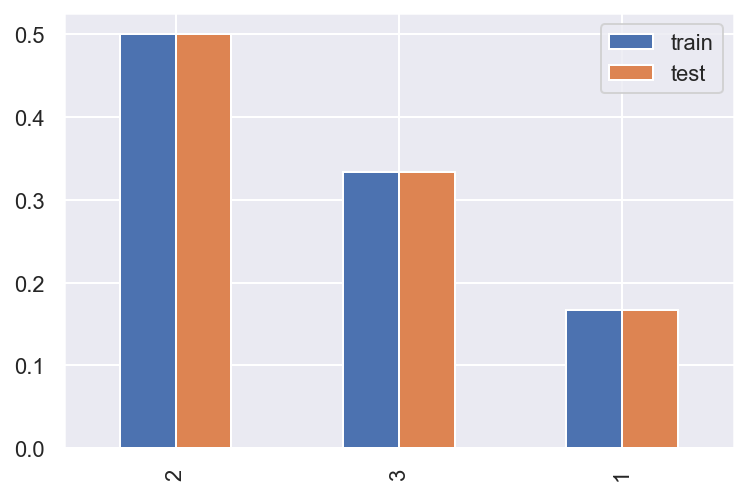

In [12]:
df_y.plot(kind='bar');

<a id='2.7'></a>
### Step 2.7: Feature Correlations

In [13]:
corr_mat = X_train.corr()
corr_mat

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
A,1.000000,0.615685,0.936640,-0.600252,0.948110,0.947113,0.942607,0.969381,0.682787,0.476810,0.937922,-0.018526,0.810431,0.878303,0.834547
B,0.615685,1.000000,0.415386,-0.858711,0.766998,0.460796,0.510704,0.721667,0.882041,-0.224991,0.756773,0.411398,0.867677,0.822184,0.854948
C,0.936640,0.415386,1.000000,-0.373523,0.828104,0.950655,0.924967,0.871956,0.463083,0.663181,0.819982,-0.188340,0.622229,0.721981,0.656270
D,-0.600252,-0.858711,-0.373523,1.000000,-0.780569,-0.424910,-0.483556,-0.725577,-0.945223,0.316953,-0.770006,-0.479802,-0.913398,-0.852953,-0.895917
E,0.948110,0.766998,0.828104,-0.780569,1.000000,0.854515,0.872478,0.980165,0.848030,0.237523,0.973046,0.160640,0.930843,0.959114,0.942299
F,0.947113,0.460796,0.950655,-0.424910,0.854515,1.000000,0.927843,0.893140,0.512804,0.619556,0.846029,-0.149270,0.664545,0.756953,0.696259
G,0.942607,0.510704,0.924967,-0.483556,0.872478,0.927843,1.000000,0.903599,0.567470,0.551365,0.863490,-0.095860,0.706743,0.787745,0.734888
H,0.969381,0.721667,0.871956,-0.725577,0.980165,0.893140,0.903599,1.000000,0.798689,0.320995,0.969117,0.100964,0.897473,0.939431,0.913351
I,0.682787,0.882041,0.463083,-0.945223,0.848030,0.512804,0.567470,0.798689,1.000000,-0.241758,0.836825,0.449823,0.956787,0.907908,0.943235
J,0.476810,-0.224991,0.663181,0.316953,0.237523,0.619556,0.551365,0.320995,-0.241758,1.000000,0.237445,-0.538283,-0.062241,0.080081,-0.016109


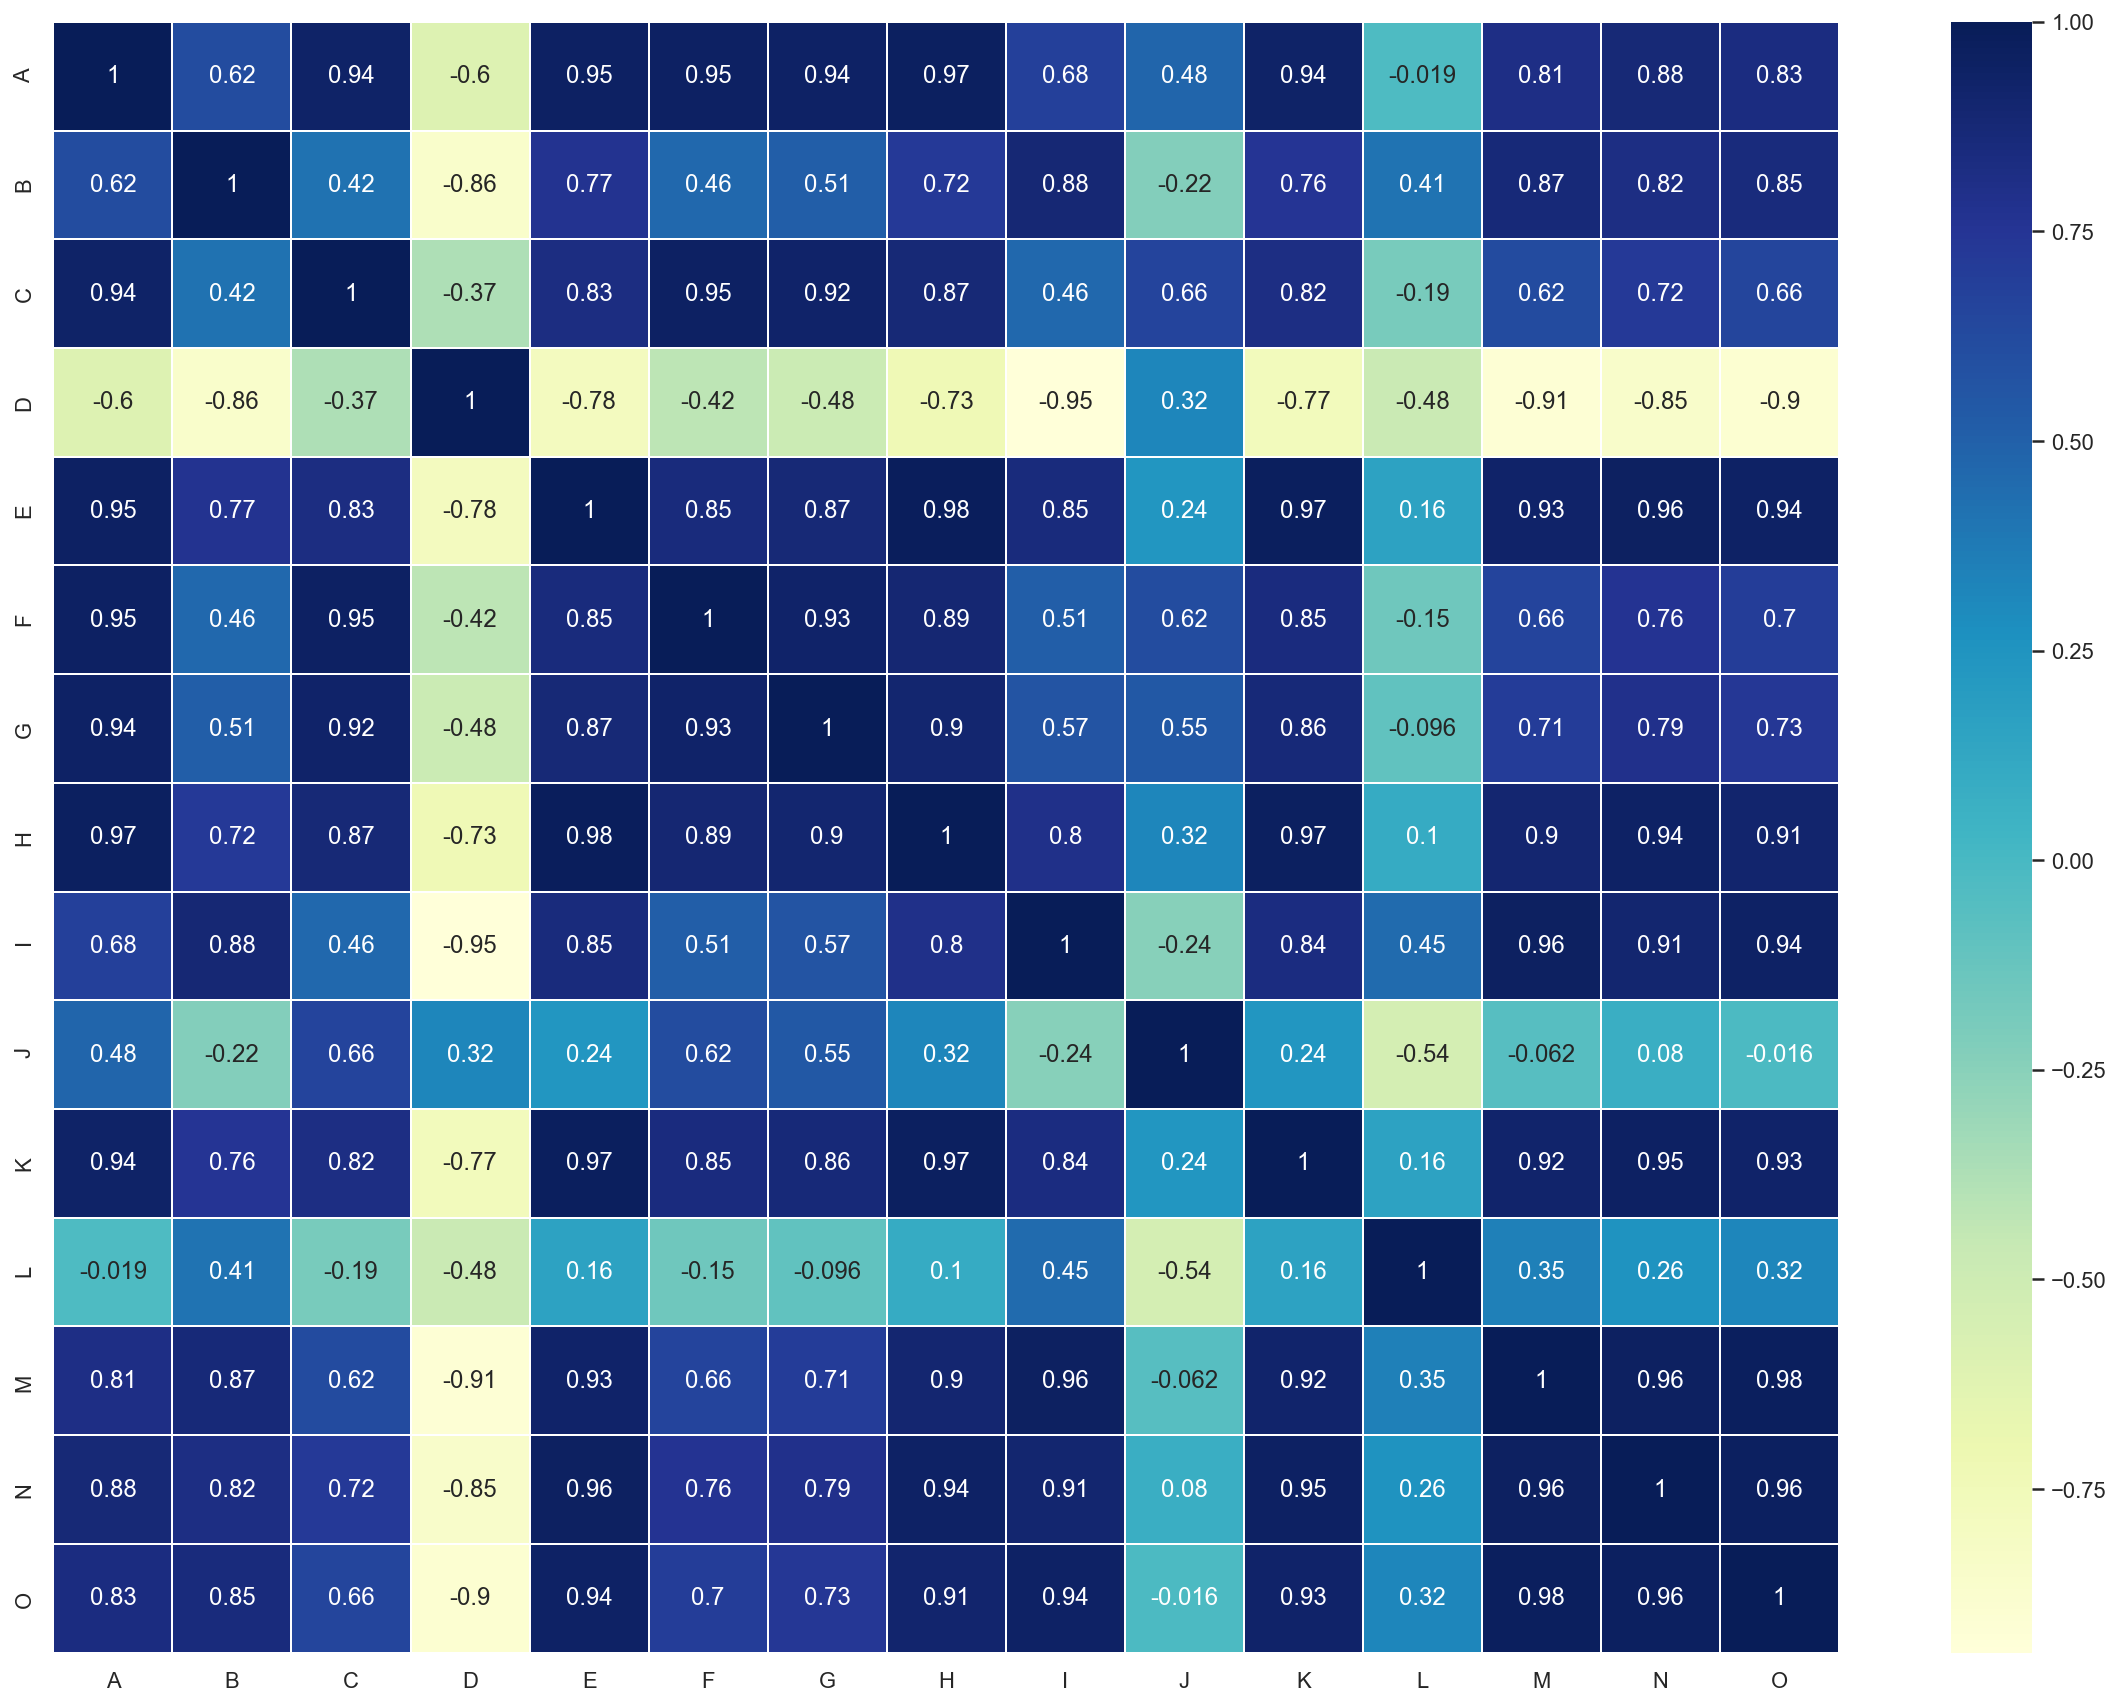

In [14]:
plt.figure(figsize=(20,15))
sns.heatmap(corr_mat, annot=True, linewidths=0.5, cmap='YlGnBu');

In [15]:
corr_mat['A'].sort_values(ascending=False)

A    1.000000
H    0.969381
E    0.948110
F    0.947113
G    0.942607
K    0.937922
C    0.936640
N    0.878303
O    0.834547
M    0.810431
I    0.682787
B    0.615685
J    0.476810
L   -0.018526
D   -0.600252
Name: A, dtype: float64

<a id='step3'></a>
## Step 3: Data Processing

The only data issues with this dataset set is that they are on different scales. Standardizing is necessary for later use.

### Step 3.1: Feature Scaling

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns.values)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns.values)

<a id='step4'></a>
## Step 4: Model Training

- Since most attributes are highly correlated, performing PCA on the dataset and use those principal components to train a model might be an efficient way to scale the computation and accuracy (see **[4.1](#4.1)**).

- From **[4.2](#4.2)**: 

    - the first principal component explained 72.3% variance
    - the second principal component explained 20.1% variance
    - the thrid principal component explained 3.28% variance
    - the remaining components explained roughly 5% variance together
    
- By plotting the first 2 or 3 principal components, we can see that those components are well linearly separated from each other.

- In the first pricipal component, the following attributes alose uniformaly capture the weights (see **[4.3](#4.3)**): 
    - E    0.3007
    - H    0.2983
    - K    0.2978
    - N    0.2956
    - O    0.2913
    - M    0.2882
    - A    0.2863
    - I    0.2652
    - G    0.2638
    - F    0.2566
    - C    0.2476
    - B    0.2437
    - D   -0.2463
    
- In the second principal component, attribute L and J captured most of the weights in opposite direction:
    - L    0.4318
    - J   -0.5333

- In the thrid principal component, attribute L captured 89.87% of the weights:
    - L    0.8987
    
- By applying the number of principal components incrementally into the logistic regression model (see **[4.4](#4.4)**), the accuracy rate, pression score, recall score and f1 score are almost idential. Thus, first three principal components that captured 95.77% variance explained are selected for later model training.

- Upon fitting and testing model built from LogisticRegression, KNearestNeighorsClassifier, SVC and DeceisionTreeClassier (see **[4.5](#4.5)**), the training and testing accuracy score, pression score, recall score and f1 score are identical which are 100%, respectively. Thus, there is no biases/variance existed in this dataset. Based on Occam's rabor principle and compuation efficiency, LogisticRegression model is chosen.

<a id='4.1'></a>
### Step 4.1: Performing Dimensionality Reduction

In [17]:
# Apply PCA to the data
pca = PCA(random_state=0)
X_train_pca = pca.fit_transform(X_train_scaled)

<a id='4.2'></a>
### Step 4.2: Visualizing PCAs

In [18]:
# Courtesy to Udacity.com
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components) + 1
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component", fontsize=16)
    ax.set_ylabel("Variance Explained (%)", fontsize=16)
    plt.title('Explained Variance Per Principal Component', fontsize=18)
    plt.xticks(range(1,16));

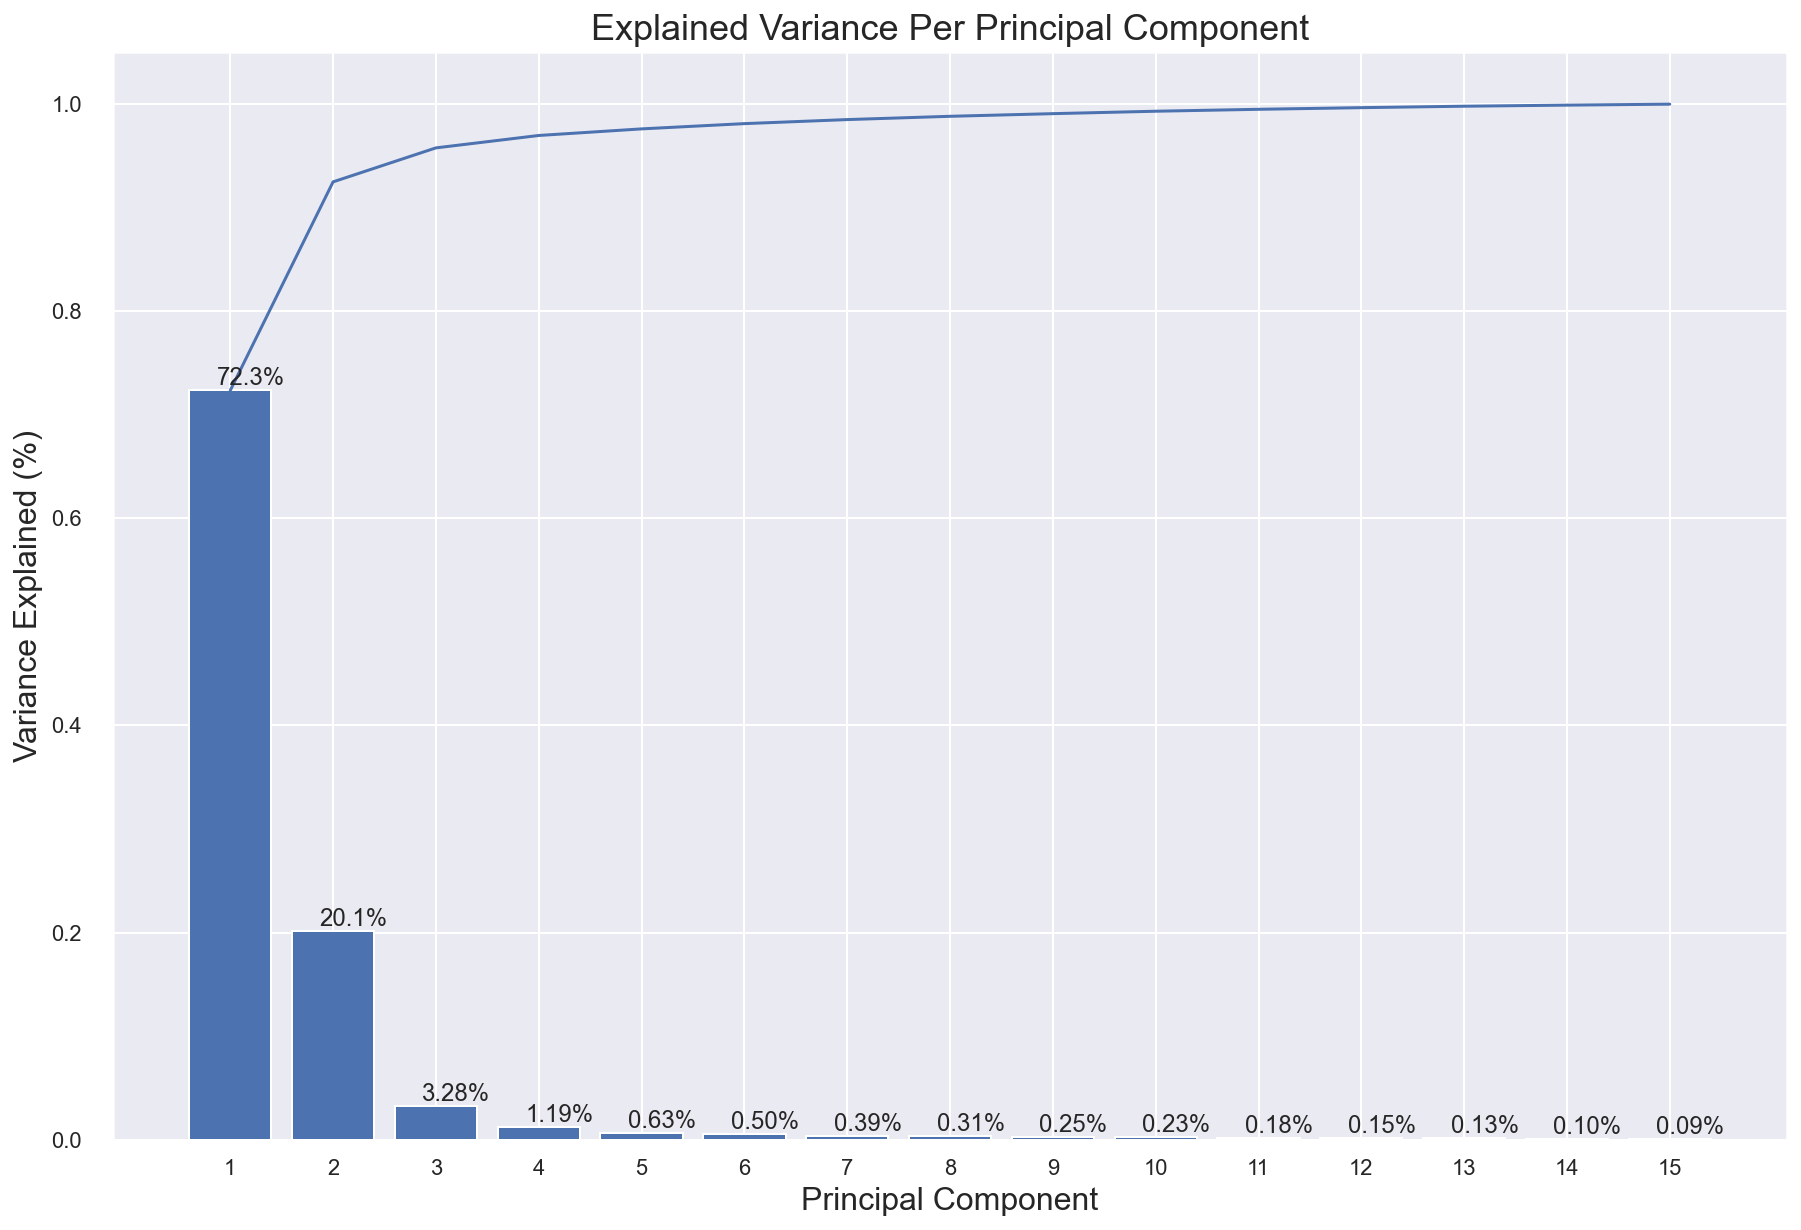

In [19]:
scree_plot(pca)

In [20]:
for i in range(1, len(pca.explained_variance_ratio_)+1):
    print('First {} component(s) explained {}% of variance in the original data.'.
        format(i, pca.explained_variance_ratio_[:i].sum())) 

First 1 component(s) explained 0.7234897454416808% of variance in the original data.
First 2 component(s) explained 0.9249558942426824% of variance in the original data.
First 3 component(s) explained 0.9577818317405772% of variance in the original data.
First 4 component(s) explained 0.9697599478459197% of variance in the original data.
First 5 component(s) explained 0.9761320465022704% of variance in the original data.
First 6 component(s) explained 0.9812061211748688% of variance in the original data.
First 7 component(s) explained 0.9851142098655387% of variance in the original data.
First 8 component(s) explained 0.9882859227330546% of variance in the original data.
First 9 component(s) explained 0.9908390722109272% of variance in the original data.
First 10 component(s) explained 0.993185876840002% of variance in the original data.
First 11 component(s) explained 0.9950460421939966% of variance in the original data.
First 12 component(s) explained 0.9966308974391948% of variance 

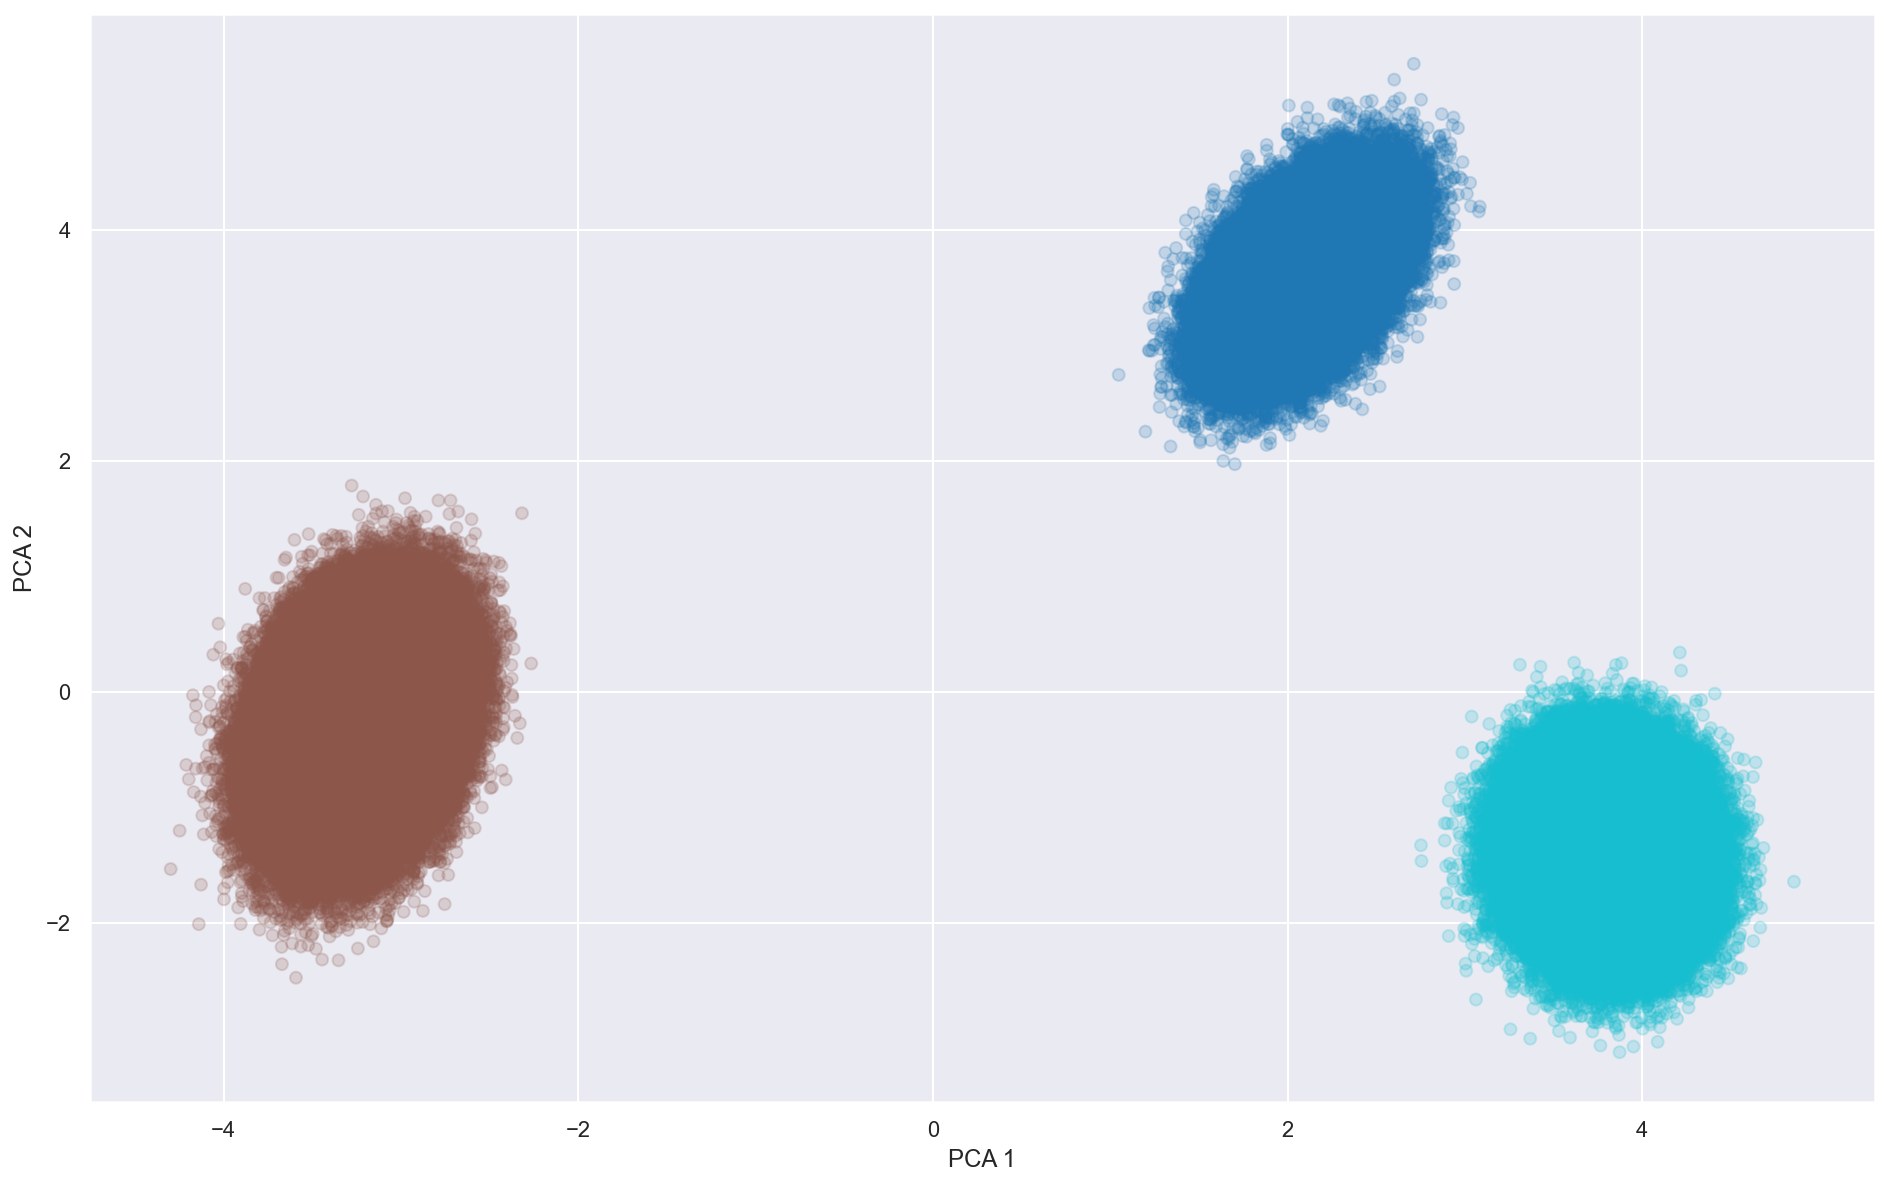

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, marker='o', cmap='tab10', alpha=0.2)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show();

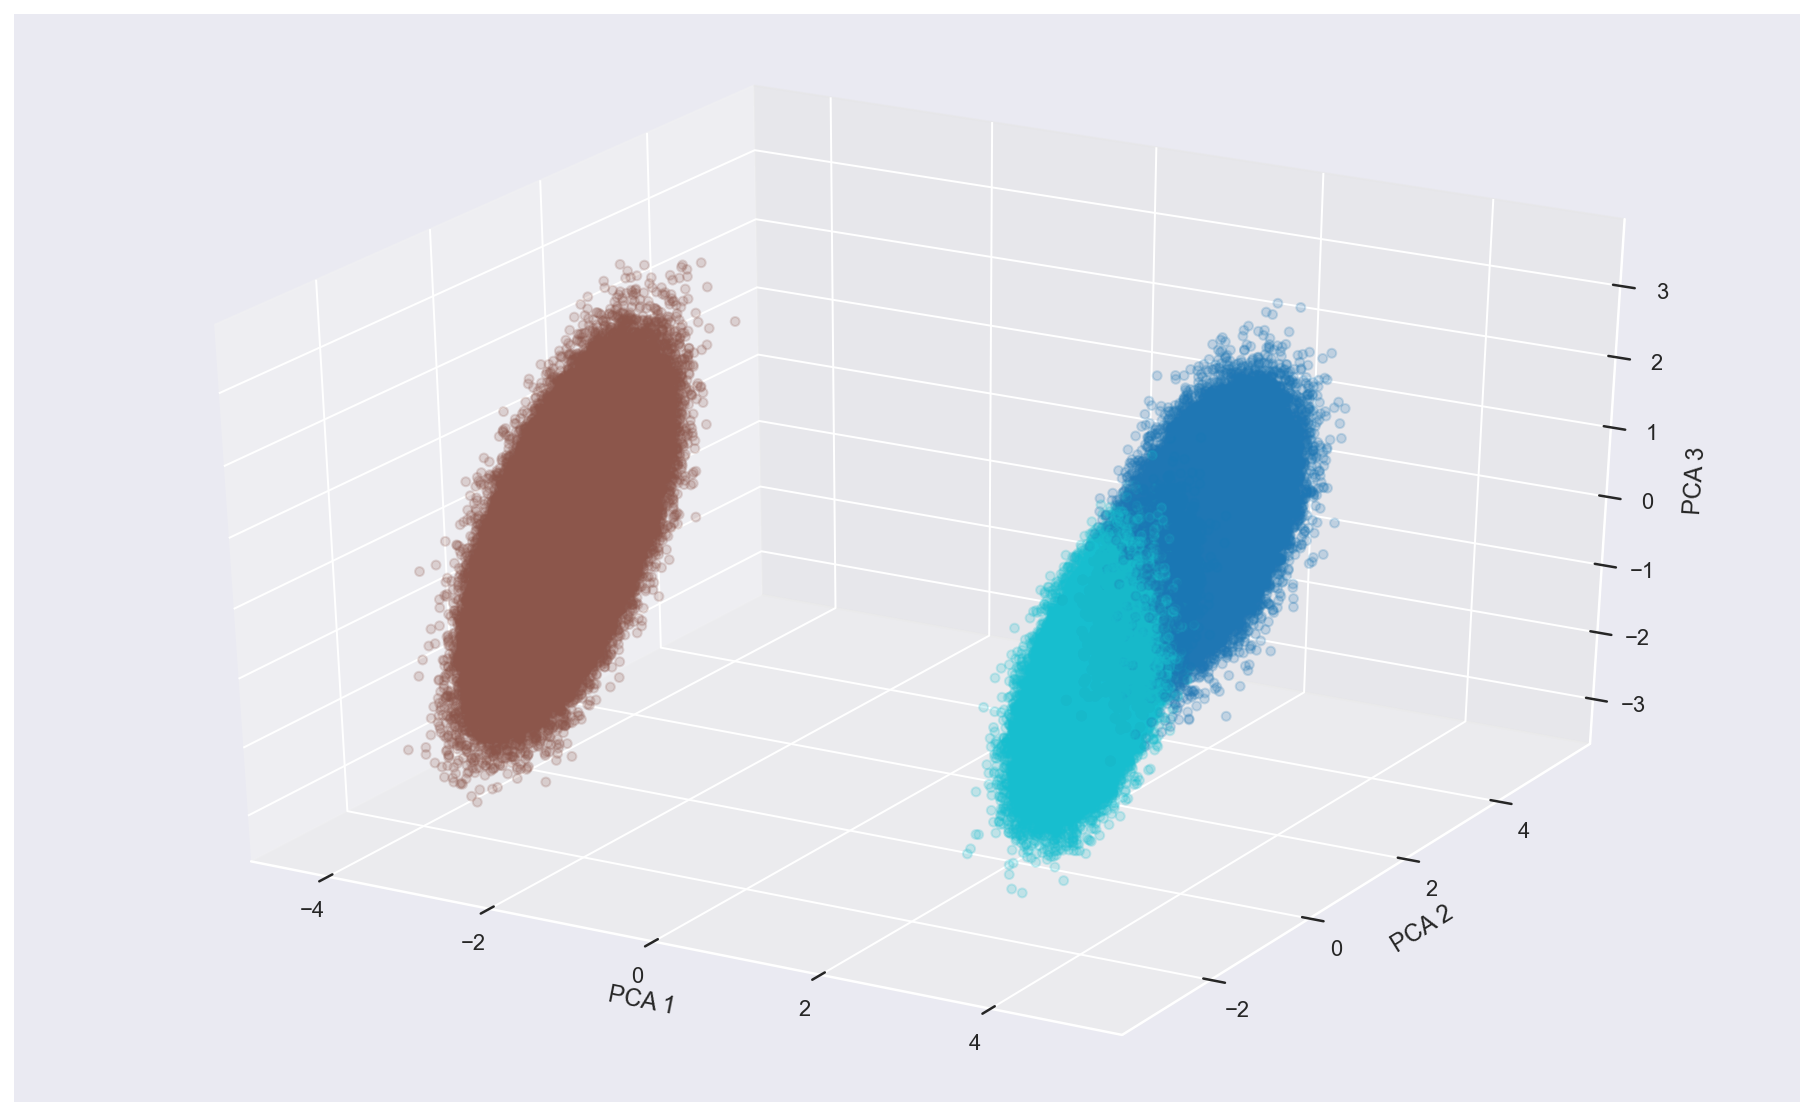

In [22]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], X_train_pca[:,2], c=y_train, marker='o', cmap='tab10', alpha=0.2)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.show();

<a id='4.3'></a>
### Step 4.3: Interpret Principal Components

In [23]:
# Courtesy to Udacity.com
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


def pca_weights(result, dimention):
    '''
    Returns the sorted feature weights in decending order for each principal component.
    '''
    return result.loc[dimention, 'A':].sort_values(ascending=False)


def plot_pca(result, dimension, figsize=(20,15)):
    '''
    Plot feature weight in descending order for a principal component.
    '''
    dim = result.loc[dimension, 'A':].sort_values(ascending=False)
    pos_dim = dim[dim>=0]
    neg_dim = dim[dim<=0]
    title = dimension + ': ' + str(np.round(result.loc[dimension, 'Explained Variance'] * 100, 2)) + '% Variance Explained'
    
    # Create a bar plot visualization
    plt.figure(figsize = figsize)
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(title, fontsize=20)
    plt.subplot(211)
    pos_dim.plot(kind = 'bar');
    plt.ylabel("Feature Weights")
    plt.grid(axis='y')
    plt.subplot(212)
    neg_dim.plot(kind = 'bar');
    plt.ylabel("Feature Weights")
    plt.grid(axis='y')

In [24]:
results = pca_results(X_train, pca)
results

,Explained Variance,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
Dimension 1,0.7235,0.2863,0.2437,0.2476,-0.2463,0.3007,0.2566,0.2638,0.2983,0.2652,0.0624,0.2978,0.0596,0.2882,0.2956,0.2913
Dimension 2,0.2015,-0.1755,0.2498,-0.3085,-0.2985,-0.0235,-0.2787,-0.2367,-0.0756,0.2561,-0.5333,-0.0251,0.4318,0.1549,0.0709,0.1281
Dimension 3,0.0328,0.0570,-0.1774,0.1203,0.1521,-0.0059,0.1083,0.0952,0.0158,-0.1226,0.2655,-0.0057,0.8987,-0.0800,-0.0467,-0.0696
Dimension 4,0.0120,0.0292,-0.9150,-0.0096,-0.1873,0.0663,0.0007,0.0215,0.0549,0.1292,-0.2517,0.0761,-0.0374,0.1043,0.0998,0.1037
Dimension 5,0.0064,0.0406,0.0750,0.1382,0.4027,-0.0118,0.1448,0.5340,0.0070,-0.1280,-0.6879,-0.0163,0.0214,-0.0775,-0.0599,-0.0721
Dimension 6,0.0051,-0.1091,-0.0044,-0.2657,-0.3866,-0.0762,-0.3351,0.7497,-0.0897,0.0119,0.2391,-0.1203,-0.0099,-0.0252,-0.0761,-0.0384
Dimension 7,0.0039,-0.0128,-0.0565,-0.2641,0.6800,0.0702,-0.4321,0.0733,0.0408,0.2916,0.1840,0.1419,-0.0165,0.1771,0.2406,0.1931
Dimension 8,0.0032,-0.0512,-0.0109,-0.7094,0.0814,-0.0183,0.6816,0.0569,-0.0317,0.0912,0.0633,-0.0555,-0.0052,0.0330,0.0276,0.0314
Dimension 9,0.0026,-0.0190,-0.0041,0.1621,0.0235,-0.0027,0.0605,0.0131,-0.0108,0.0712,0.0197,-0.8106,-0.0020,0.0245,0.5522,0.0285
Dimension 10,0.0023,-0.0075,-0.0187,0.1707,0.0929,0.0558,0.0767,0.0164,0.0353,0.4766,0.0488,-0.3748,-0.0059,0.1689,-0.6966,0.2599


In [25]:
pca_weights(results, 'Dimension 1')

E    0.3007
H    0.2983
K    0.2978
N    0.2956
O    0.2913
M    0.2882
A    0.2863
I    0.2652
G    0.2638
F    0.2566
C    0.2476
B    0.2437
J    0.0624
L    0.0596
D   -0.2463
Name: Dimension 1, dtype: float64

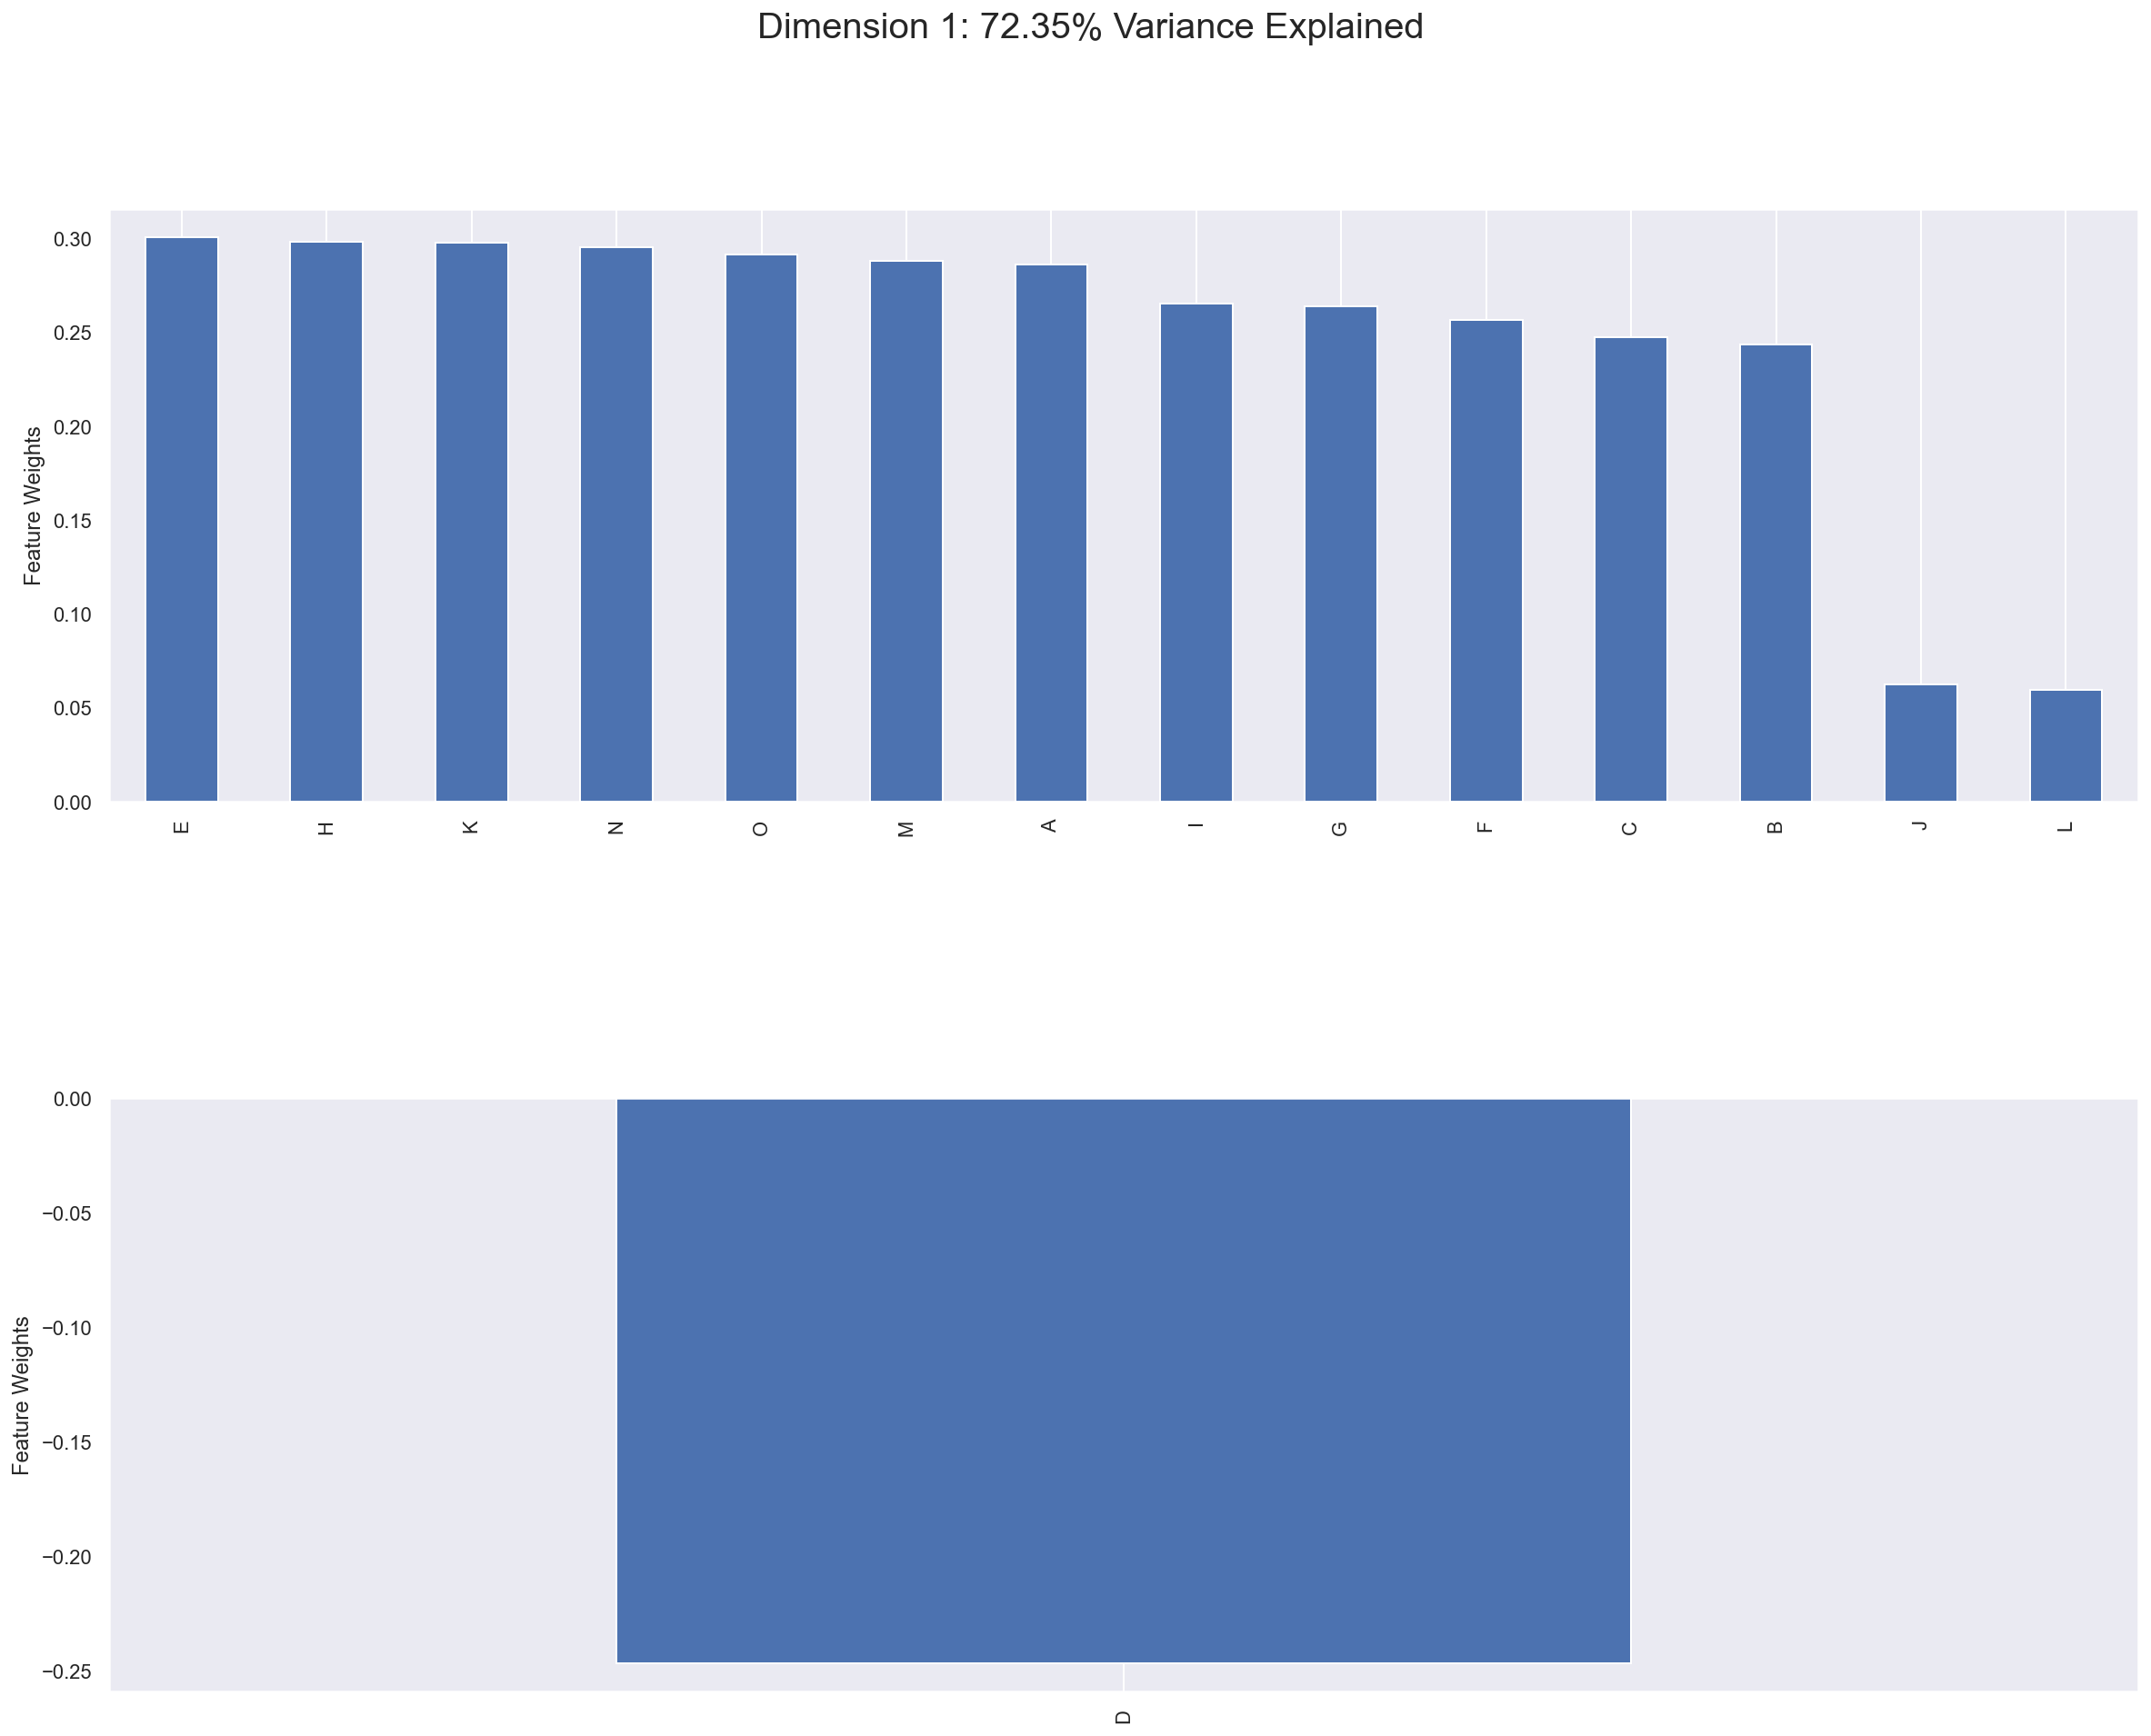

In [26]:
plot_pca(results, 'Dimension 1')

In [27]:
pca_weights(results, 'Dimension 2')

L    0.4318
I    0.2561
B    0.2498
M    0.1549
O    0.1281
N    0.0709
E   -0.0235
K   -0.0251
H   -0.0756
A   -0.1755
G   -0.2367
F   -0.2787
D   -0.2985
C   -0.3085
J   -0.5333
Name: Dimension 2, dtype: float64

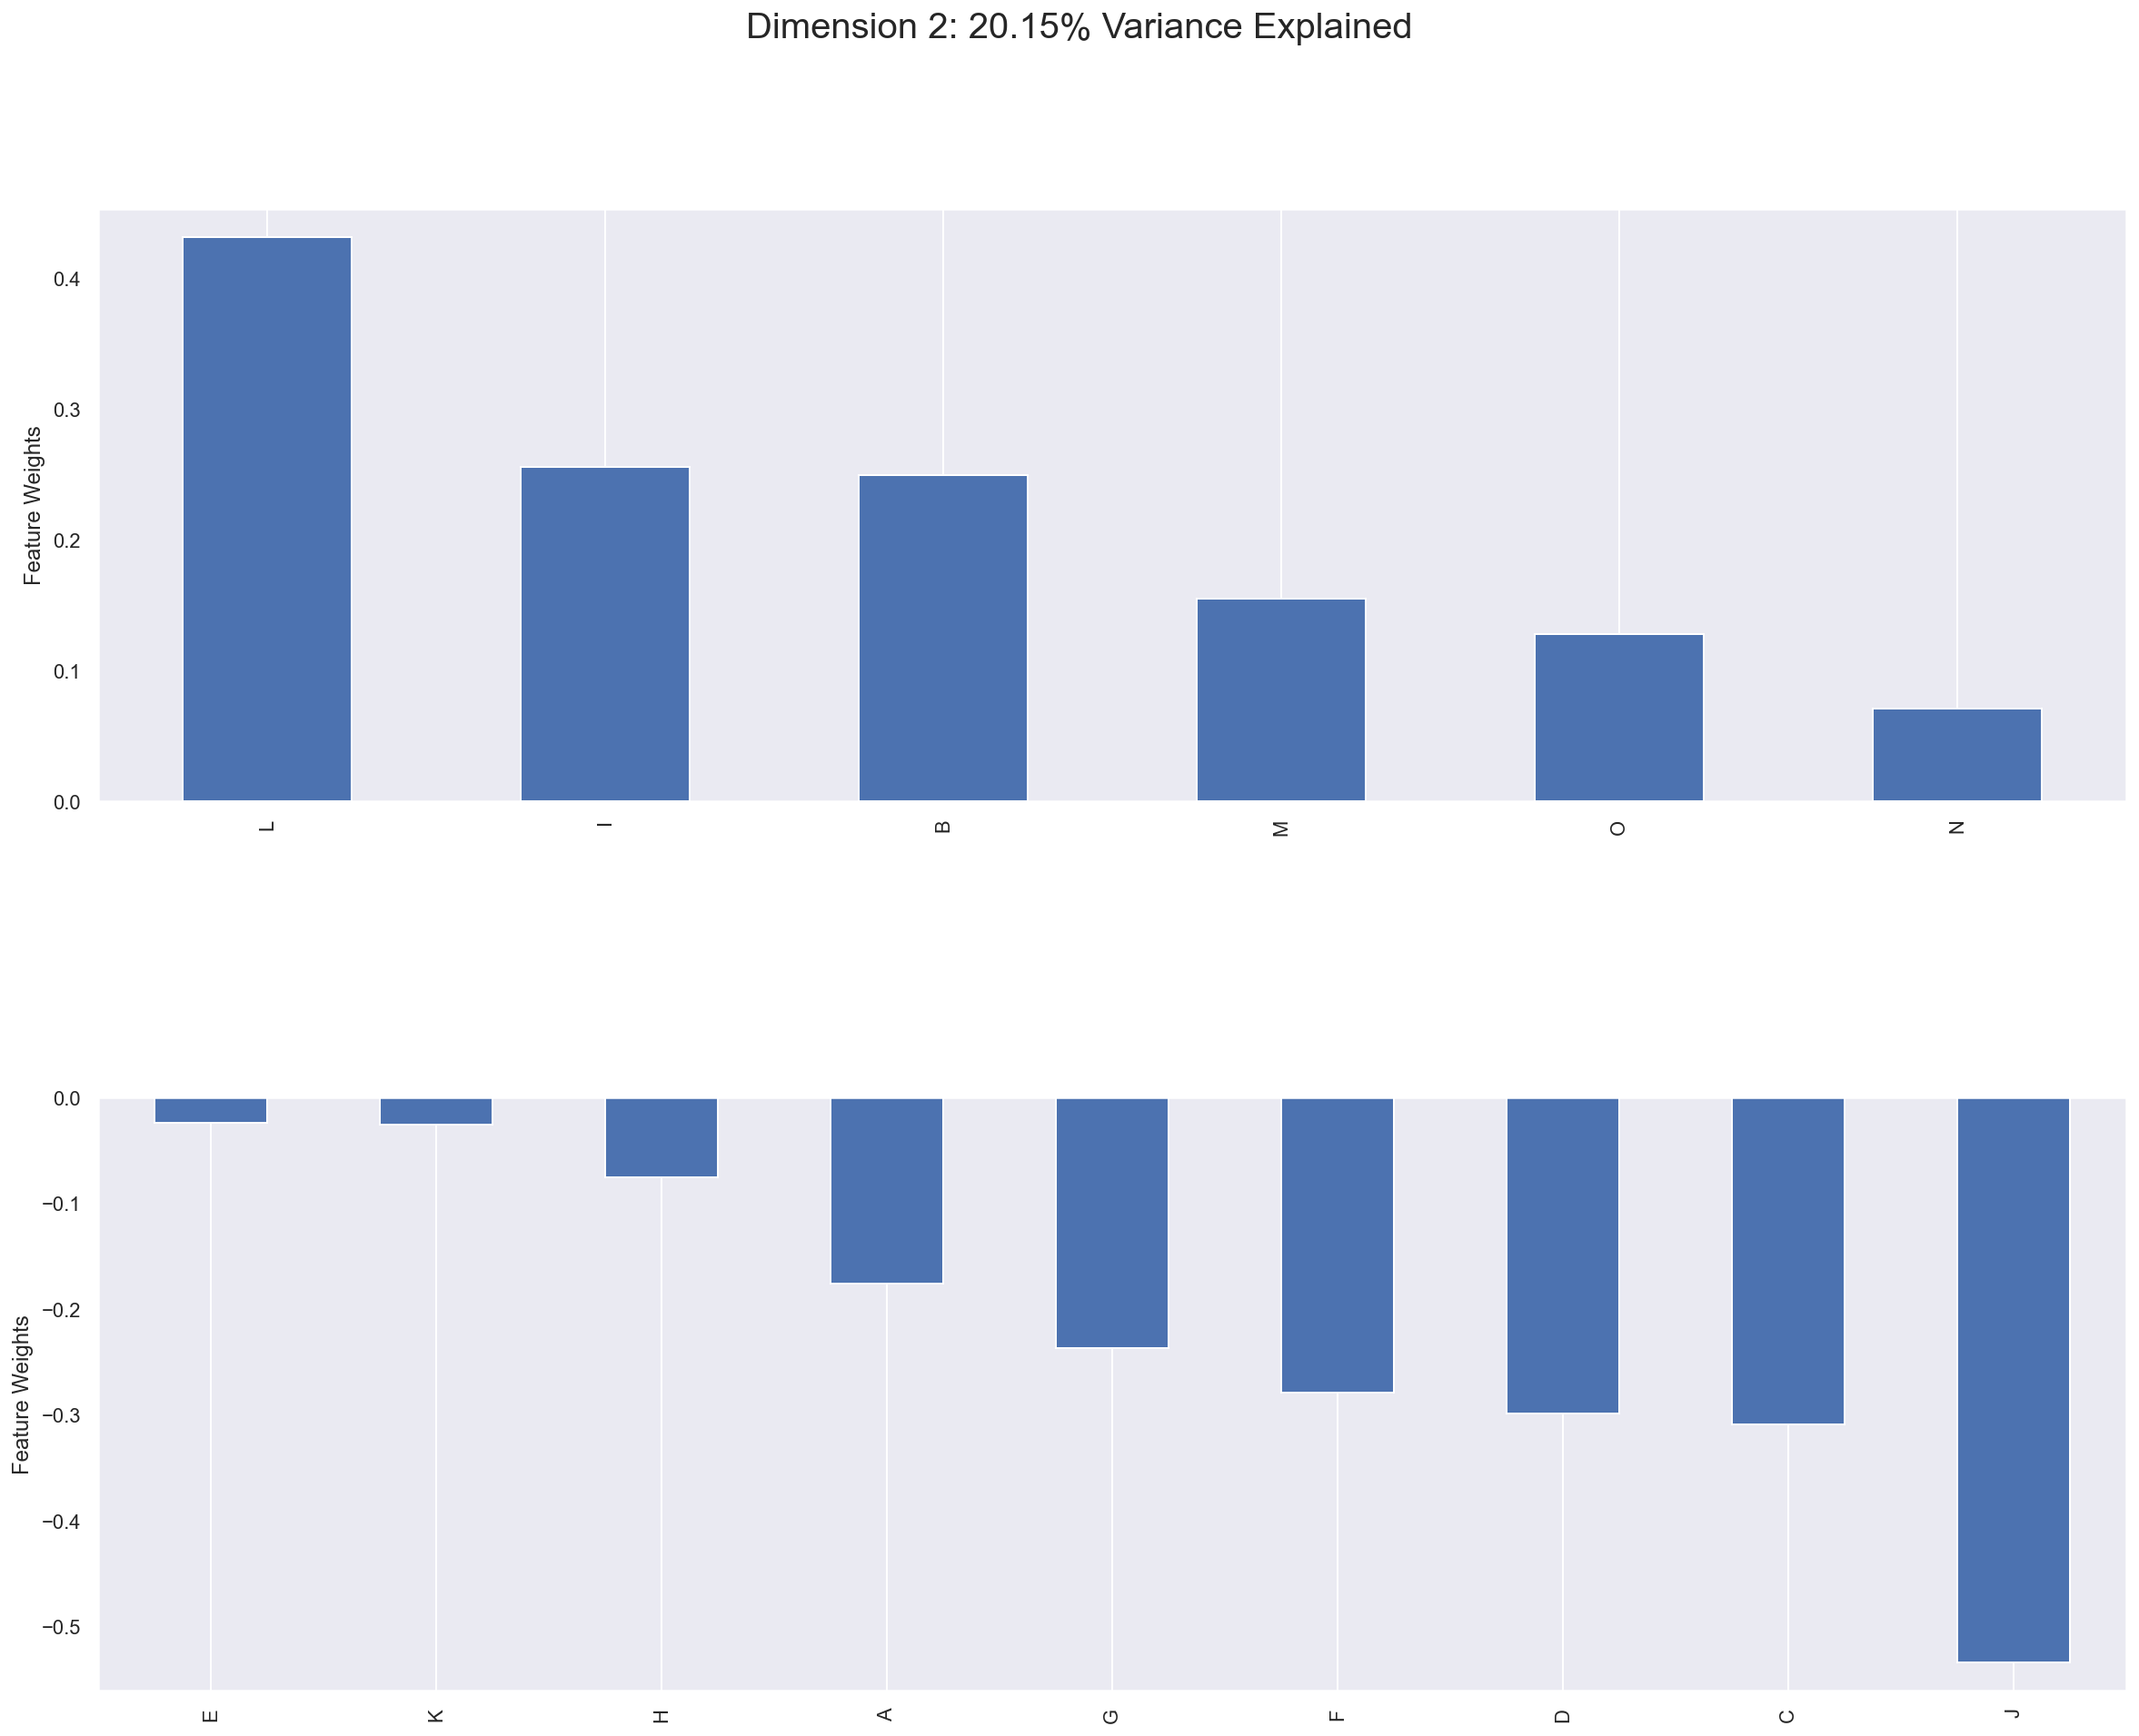

In [28]:
plot_pca(results, 'Dimension 2')

In [29]:
pca_weights(results, 'Dimension 3')

L    0.8987
J    0.2655
D    0.1521
C    0.1203
F    0.1083
G    0.0952
A    0.0570
H    0.0158
K   -0.0057
E   -0.0059
N   -0.0467
O   -0.0696
M   -0.0800
I   -0.1226
B   -0.1774
Name: Dimension 3, dtype: float64

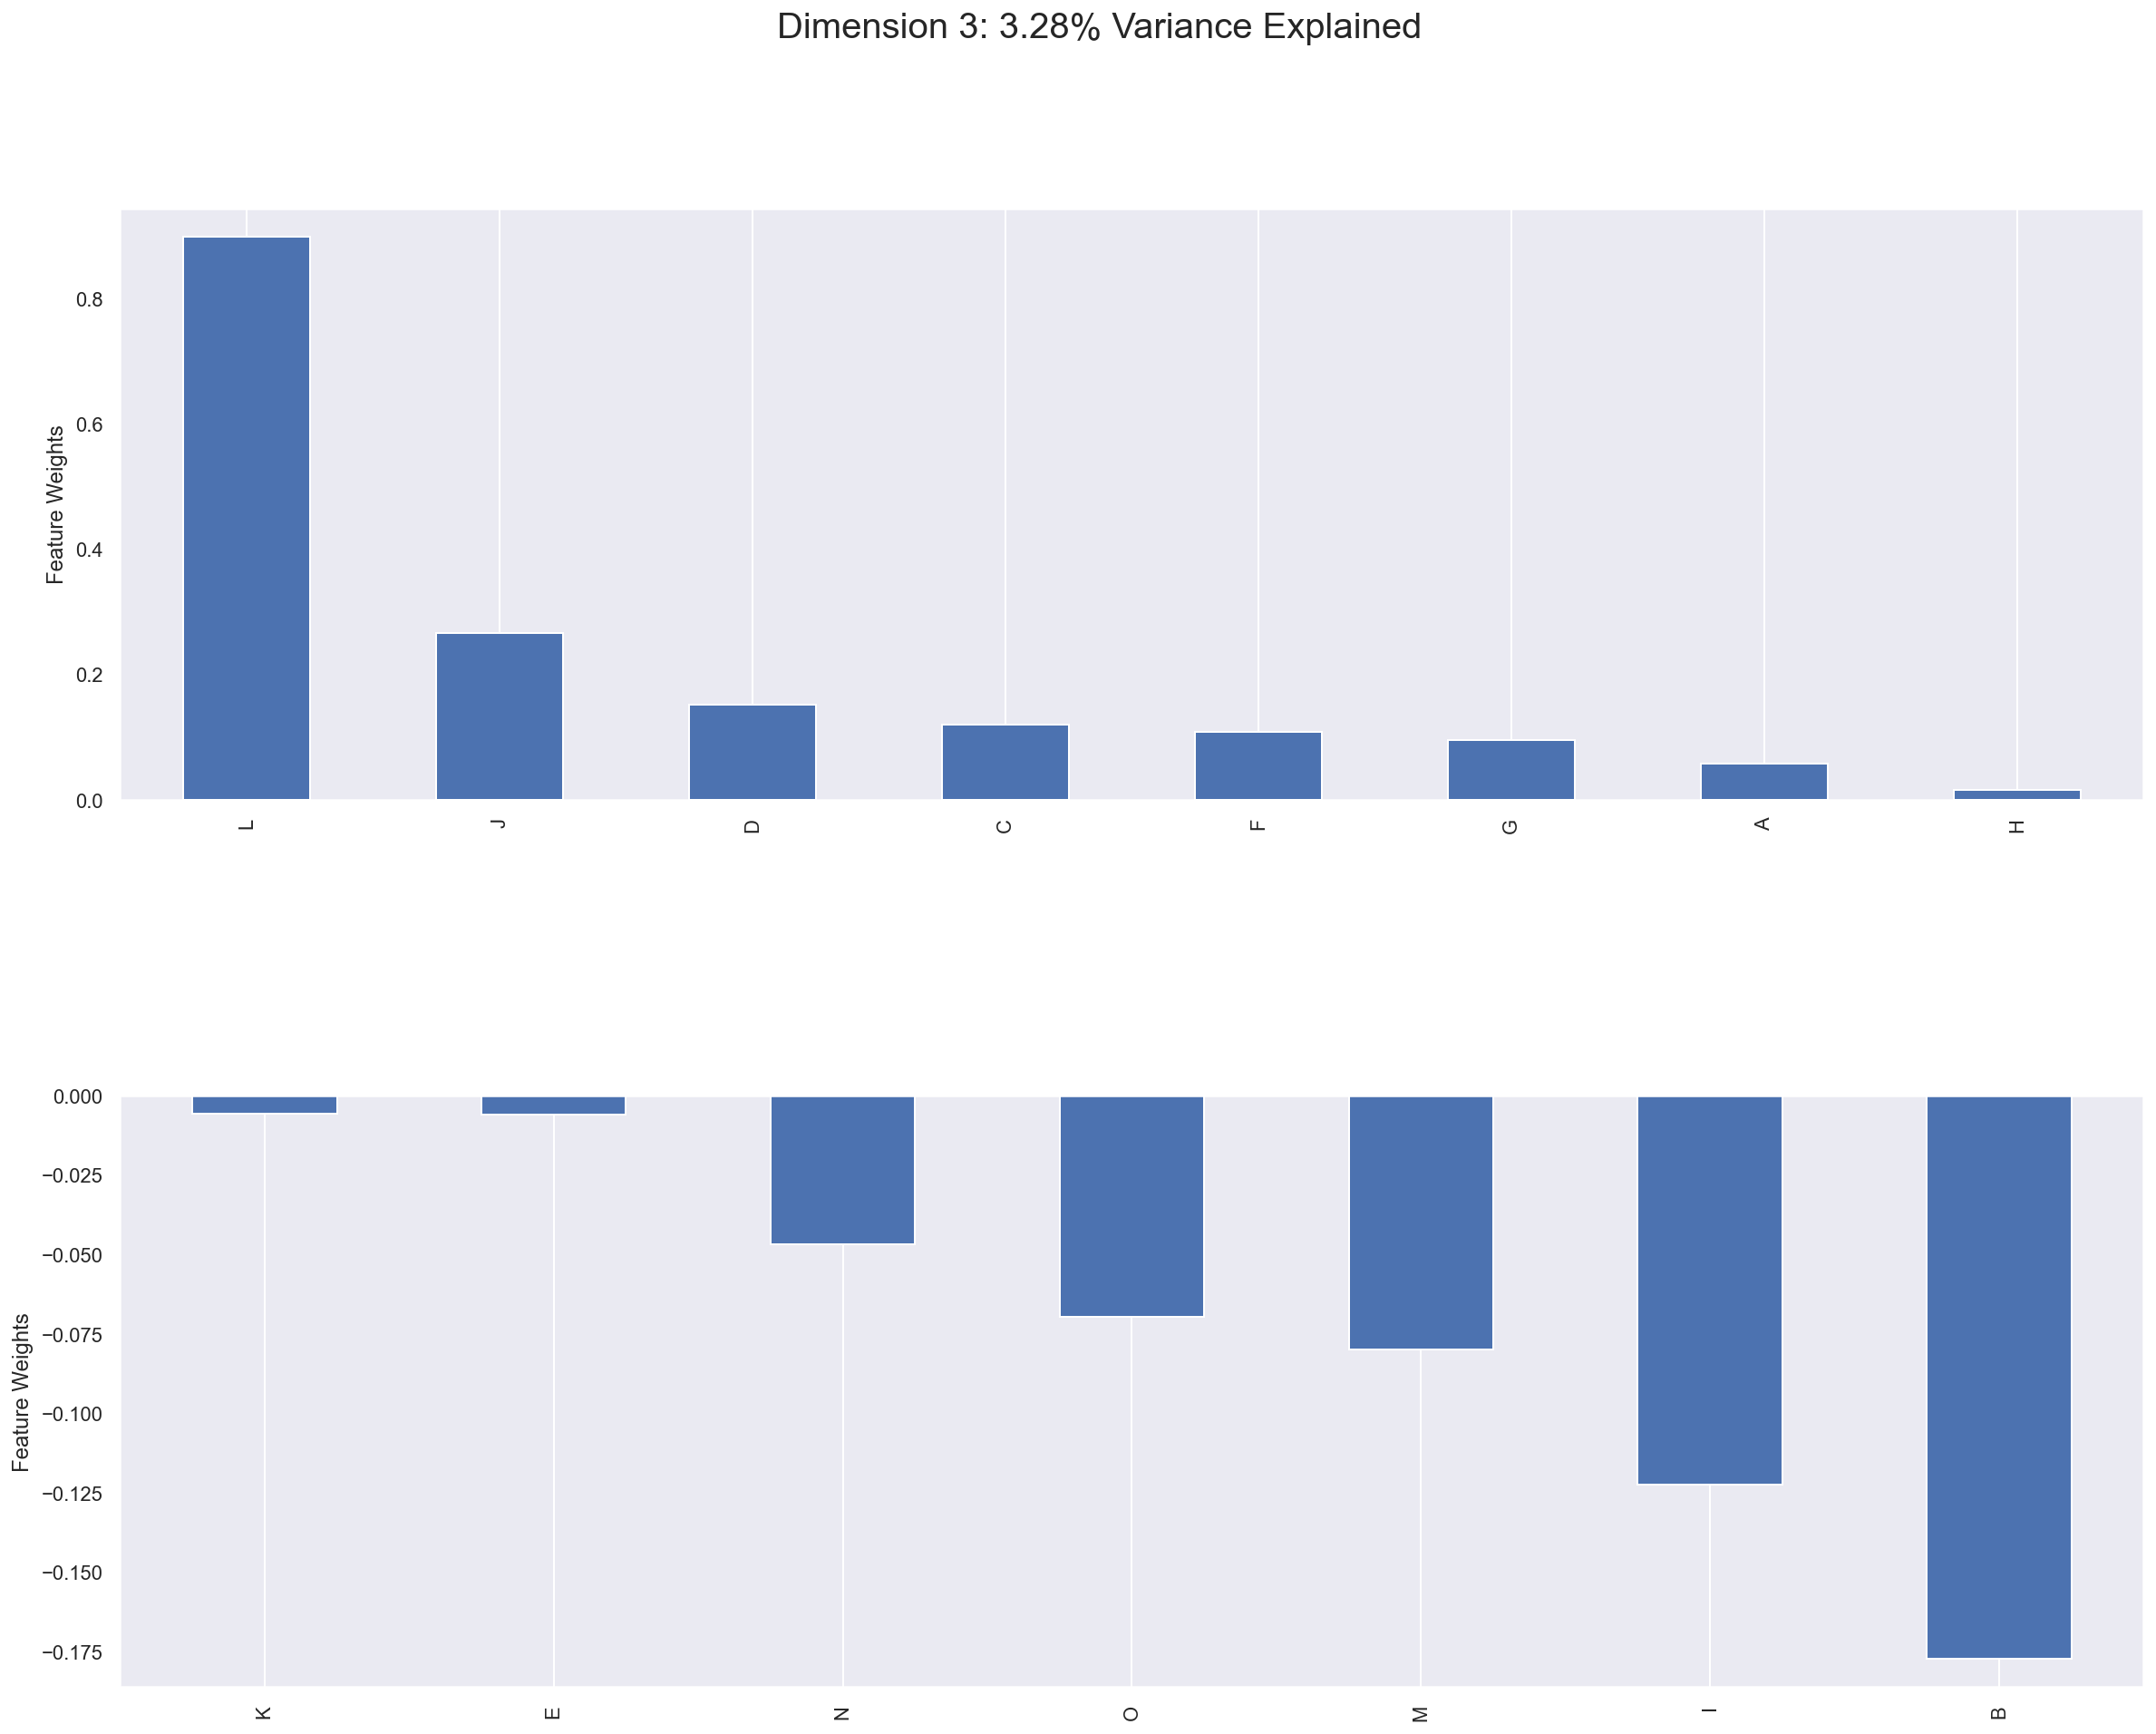

In [30]:
plot_pca(results, 'Dimension 3')

<a id='4.4'></a>
### Step 4.4: PCA Selection

In [31]:
def print_metrics(y_true, y_pred, dev='training'):
    """
    Print out classification metrics
    """
    target_names = ['class 1', 'class 2', 'class 3']
    print('The', dev, 'metrics:')
    print(classification_report(y_true, y_pred, target_names=target_names))

In [32]:
X_test_pca = pca.transform(X_test_scaled)

In [33]:
for i in range(1, 6):
    logit_mod = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0)
    logit_mod.fit(X_train_pca[:, :i], y_train)
    y_pred = logit_mod.predict(X_test_pca[:,:i])
    print('Fist', i, 'PCA(s)')
    print_metrics(y_test, y_pred, 'testing')

Fist 1 PCA(s)
The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000

Fist 2 PCA(s)
The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000

Fist 3 PCA(s)
The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00 

In [34]:
# Re-apply PCA to the data with the number of components to retain
n_components = 3
pca = PCA(n_components, random_state=0)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

<a id='4.5'></a>
### Step 4.5:  Model Selection

In [35]:
# Logistic Regression
logit_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0)
logit_clf.fit(X_train_pca, y_train)
y_pred = logit_clf.predict(X_train_pca)
print_metrics(y_train, y_pred)
y_pred = logit_clf.predict(X_test_pca)
print_metrics(y_test, y_pred, dev='testing')

The training metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00    150077
     class 2       1.00      1.00      1.00    449873
     class 3       1.00      1.00      1.00    300050

    accuracy                           1.00    900000
   macro avg       1.00      1.00      1.00    900000
weighted avg       1.00      1.00      1.00    900000

The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



In [36]:
# KNN
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_pca, y_train)
y_pred = knn_clf.predict(X_train_pca)
print_metrics(y_train, y_pred)
y_pred = knn_clf.predict(X_test_pca)
print_metrics(y_test, y_pred, dev='testing')

The training metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00    150077
     class 2       1.00      1.00      1.00    449873
     class 3       1.00      1.00      1.00    300050

    accuracy                           1.00    900000
   macro avg       1.00      1.00      1.00    900000
weighted avg       1.00      1.00      1.00    900000

The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



In [37]:
# SVC
svc_clf = SVC(random_state=0)
svc_clf.fit(X_train_pca, y_train)
y_pred = svc_clf.predict(X_train_pca)
print_metrics(y_train, y_pred)
y_pred = svc_clf.predict(X_test_pca)
print_metrics(y_test, y_pred, dev='testing')

The training metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00    150077
     class 2       1.00      1.00      1.00    449873
     class 3       1.00      1.00      1.00    300050

    accuracy                           1.00    900000
   macro avg       1.00      1.00      1.00    900000
weighted avg       1.00      1.00      1.00    900000

The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



In [38]:
# Decision tree
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train_pca, y_train)
y_pred = tree_clf.predict(X_train_pca)
print_metrics(y_train, y_pred)
y_pred = tree_clf.predict(X_test_pca)
print_metrics(y_test, y_pred, dev='testing')

The training metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00    150077
     class 2       1.00      1.00      1.00    449873
     class 3       1.00      1.00      1.00    300050

    accuracy                           1.00    900000
   macro avg       1.00      1.00      1.00    900000
weighted avg       1.00      1.00      1.00    900000

The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



<a id='step5'></a>
## Step 5: Putting All Together

- The data pipeline consists of the following components (see **[5.1](#5.1)**):

    - Feature transformer
        - SimpleImputer with median strategy
        - SdandardScaler
        - PCA with 3 components
        
    - Preprocessor
        - ColumnTransformer that apply Feature transformer to all features
        
    - Classifier
        - LogisticRegression with `multi_class = multinomail` and `solver = lbfgs`
        
- The ONNX based model for testing with a runtime session in onnx format (see **[5.2](#5.2)**):
    
    - Use `convert_sklearn` to convert the aforementioined data pipeline into an ONNX based model and save it to `public_pipeline.onnx`
    
    - Use `GetPydotGraph` to display the computation graph of the ONNX model
    
- The whole project can be runned from the `run_app` function

<a id='5.1'></a>
### Step5.1: Building Data Pipeline

In [39]:
features = list(X_train)

feature_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3, random_state=0))
])

preprocessor = ColumnTransformer(transformers=[('features', feature_transformer, features)])

classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('features',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [41]:
y_pred = pipeline.predict(X_test)

In [42]:
print_metrics(y_test, y_pred, 'testing')

The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



In [43]:
pipeline = PMMLPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print_metrics(y_test, y_pred, 'testing')

sklearn2pmml(pipeline,
             'Scikit_Learn_public_pipeline.pmml',
             with_repr = True)

The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



In [44]:
def build_pipeline(X):
    features = list(X)

    feature_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=3, random_state=0))
    ])

    preprocessor = ColumnTransformer(transformers=[('features', feature_transformer, features)])

    classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    return pipeline

<a id='5.2'></a>
### Step 5.2: ONNX Based Model

In [45]:
input_types = dict([(x, FloatTensorType([None, 1])) for x in X_train.columns.values])

try:
    model_onnx = convert_sklearn(pipeline,
                                'pipeline_public_onnx',
                                initial_types=list(input_types.items()))
except Exception as e:
    print(e)
    
with open('ONNX_public_pipeline.onnx', 'wb') as f:
    f.write(model_onnx.SerializeToString())

In [46]:
inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("ONNX_public_pipeline.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx[0])

predict [1 3 2 ... 3 1 2]


In [47]:
print_metrics(y_test, predict_onnx[0], 'testing')

The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



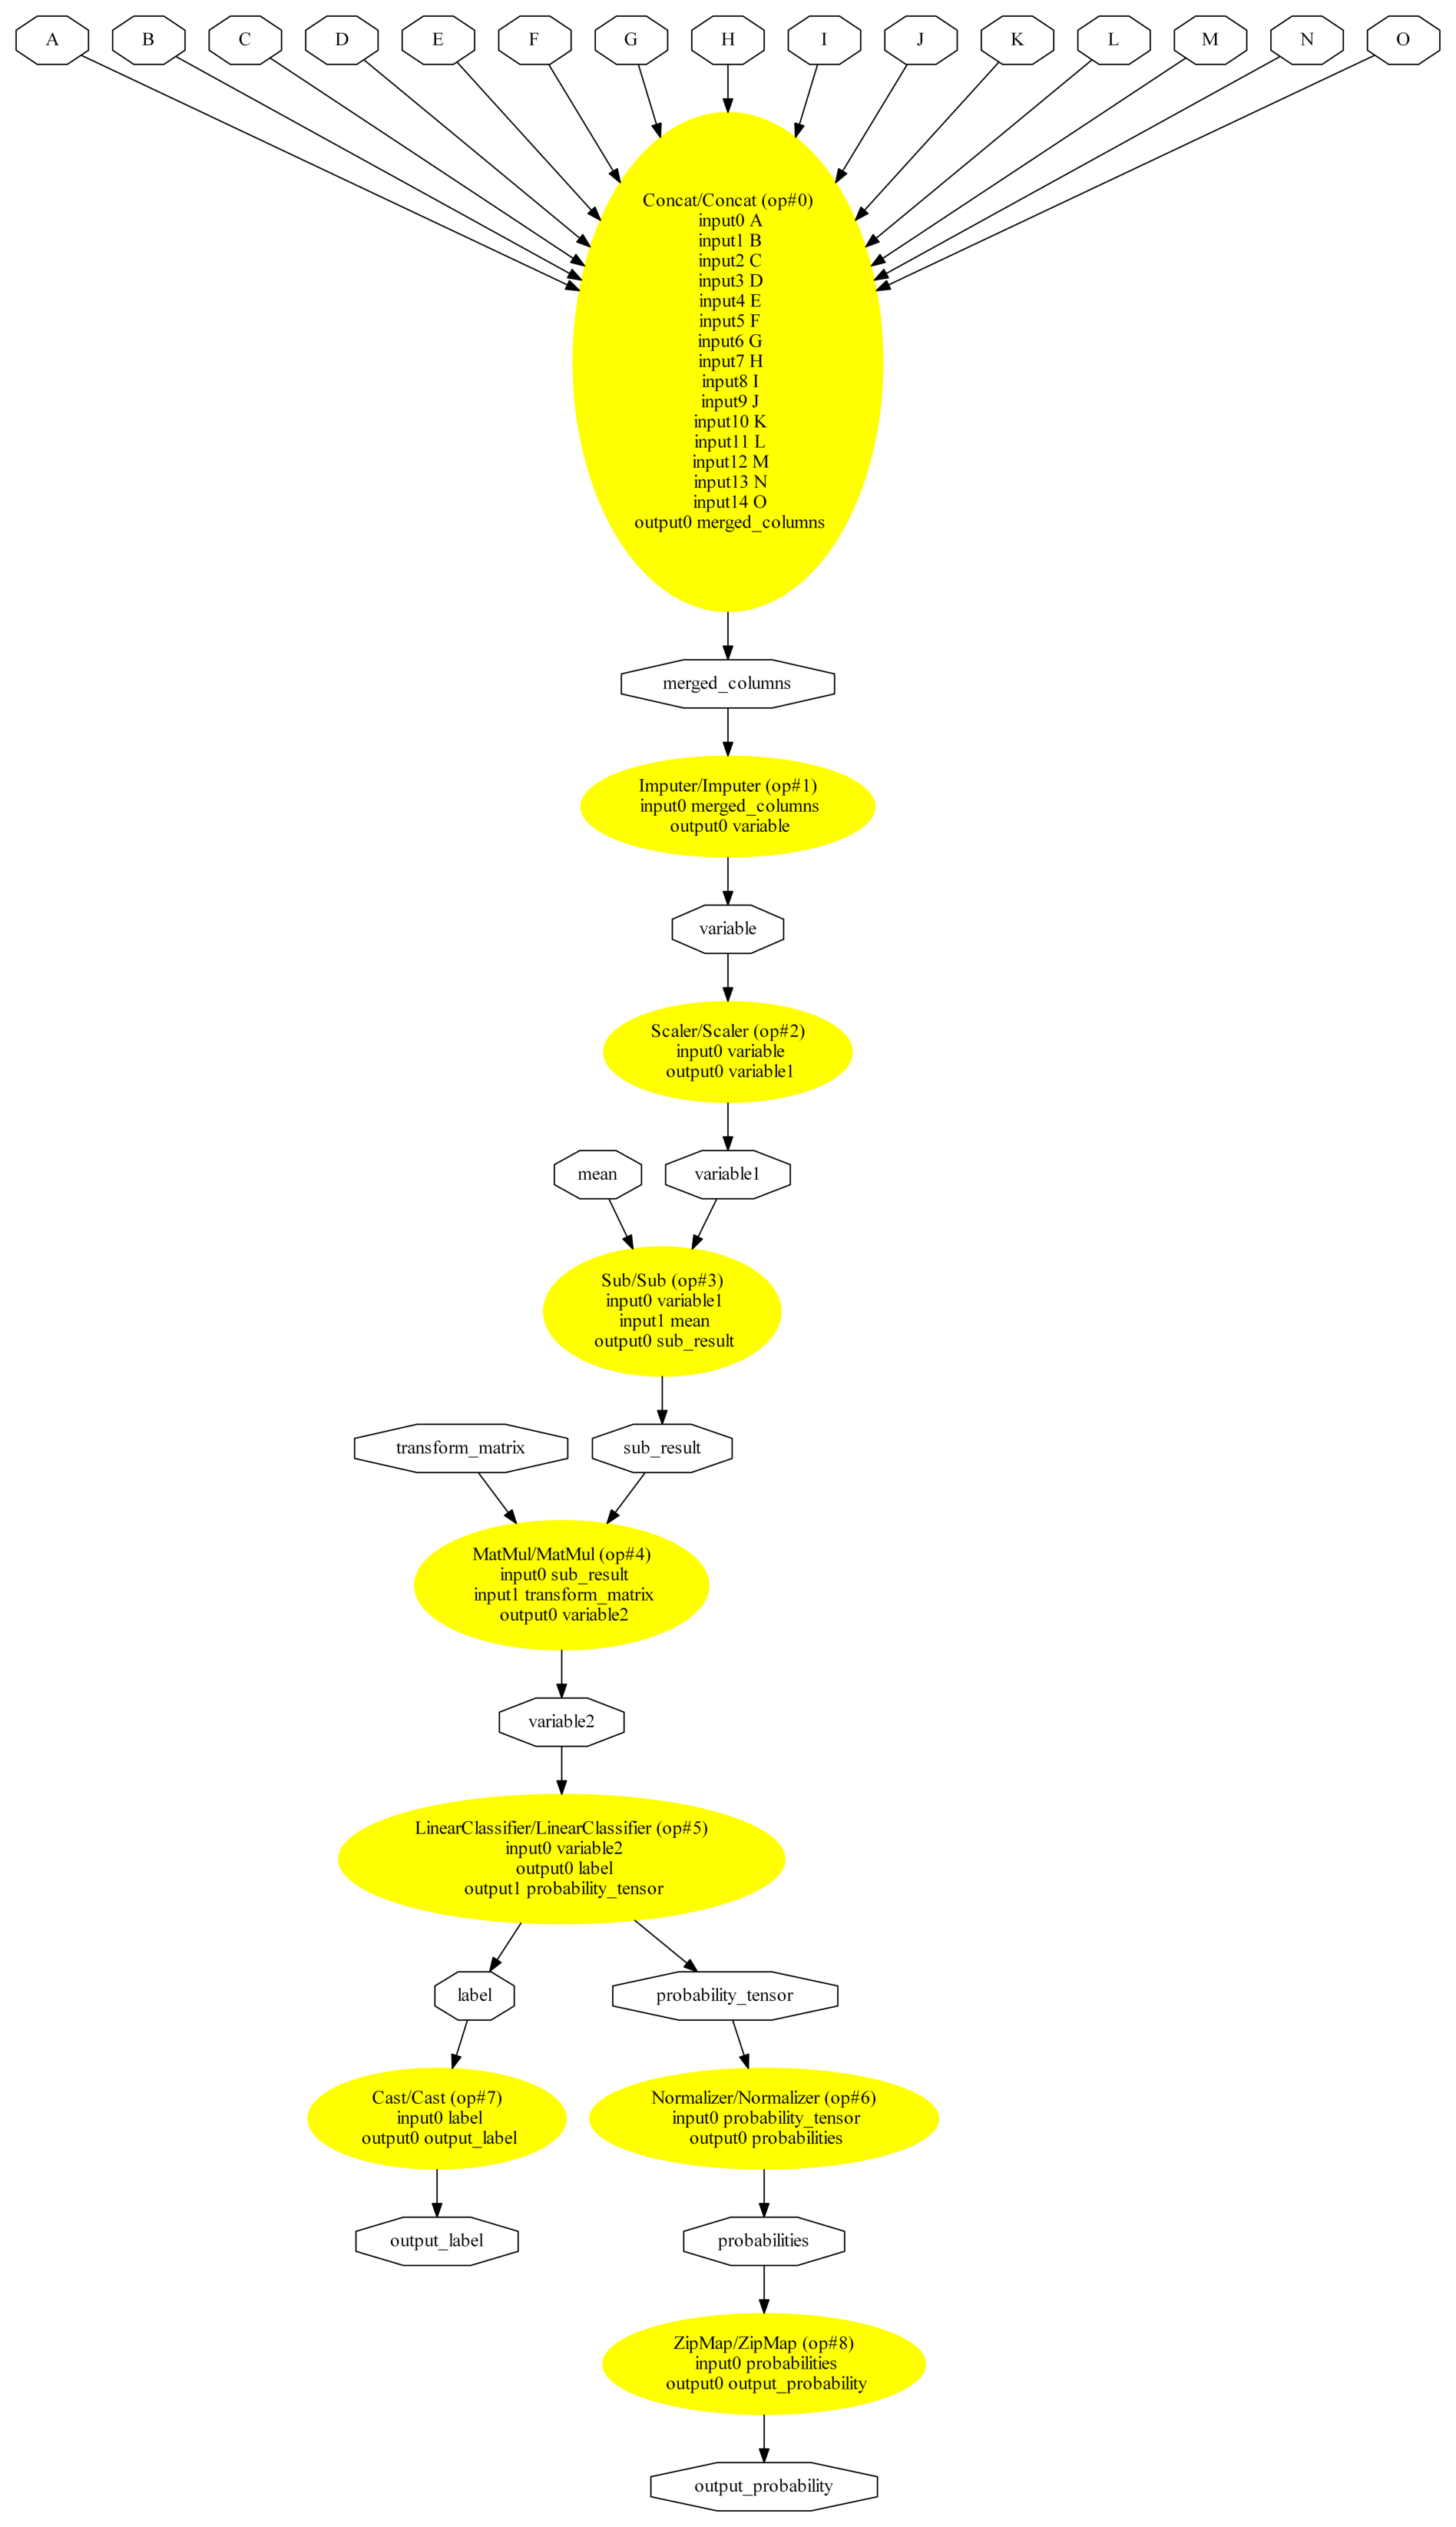

In [48]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="yellow",
                                                            style="filled"))

pydot_graph.write_dot('ONNX_public_pipeline.dot')

os.system('dot -O -Gdpi=600 -Tpng ONNX_public_pipeline.dot')

image = plt.imread('ONNX_public_pipeline.dot.png')
fig, ax = plt.subplots(figsize=(50,30))
ax.imshow(image)
ax.axis('off');

### Step 5.3: Final Algorithm

In [49]:
def build_model_onnx(X, pipeline, model_name='ONNX_data_pipeline.onnx'):
    input_types = dict([(x, FloatTensorType([None, 1])) for x in X_train.columns.values])

    try:
        model_onnx = convert_sklearn(pipeline,
                                    'pipeline_onnx',
                                    initial_types=list(input_types.items()))
    except Exception as e:
        print(e)

    with open(model_name, 'wb') as f:
        f.write(model_onnx.SerializeToString())
        
    return model_onnx

In [50]:
def run_onnx(X_test):
    inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}
    session_onnx = rt.InferenceSession("ONNX_public_pipeline.onnx")
    predict_onnx = session_onnx.run(None, inputs_onnx)
    
    return predict_onnx[0]

In [51]:
def display_onnx_model(model_onnx):
    pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="yellow",
                                                            style="filled"))

    pydot_graph.write_dot('ONNX_data_pipeline.dot')

    os.system('dot -O -Gdpi=600 -Tpng ONNX_data_pipeline.dot')

    image = plt.imread('ONNX_data_pipeline.dot.png')
    fig, ax = plt.subplots(figsize=(50,30))
    ax.imshow(image)
    ax.axis('off');

In [52]:
def run_app():
    # Load data
    print('Loading data ...')
    X_train, X_test, y_train, y_test = load_data()
    print('Data loaded')

    
    # Build pipeline
    print('Building pipeline ...')
    pipeline = build_pipeline(X_train)
    print('Pipeline built')
    
    # Train pipeline
    print('Fitting pipeline ...')
    pipeline.fit(X_train, y_train)
    print('Pipeline fitted')
    
    # Build onnx model
    print('Building onnx model ...')
    model_onnx = build_model_onnx(X_train, pipeline)
    print('Onnx model built')
    
    # Predict using onnx model
    print('Running onnx inference ...')
    predictions = run_onnx(X_test)
    print('Inference completed')
    print('predict:', predictions)
    print('Model performance:')
    print_metrics(y_test, predictions, 'testing')
    
    # Display onnx computation graph
    print('Displaying computation graph')
    display_onnx_model(model_onnx)

Loading data ...
Data loaded
Building pipeline ...
Pipeline built
Fitting pipeline ...
Pipeline fitted
Building onnx model ...
Onnx model built
Running onnx inference ...
Inference completed
predict: [1 3 2 ... 3 1 2]
Model performance:
The testing metrics:
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00     50026
     class 2       1.00      1.00      1.00    149958
     class 3       1.00      1.00      1.00    100016

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000

Displaying computation graph


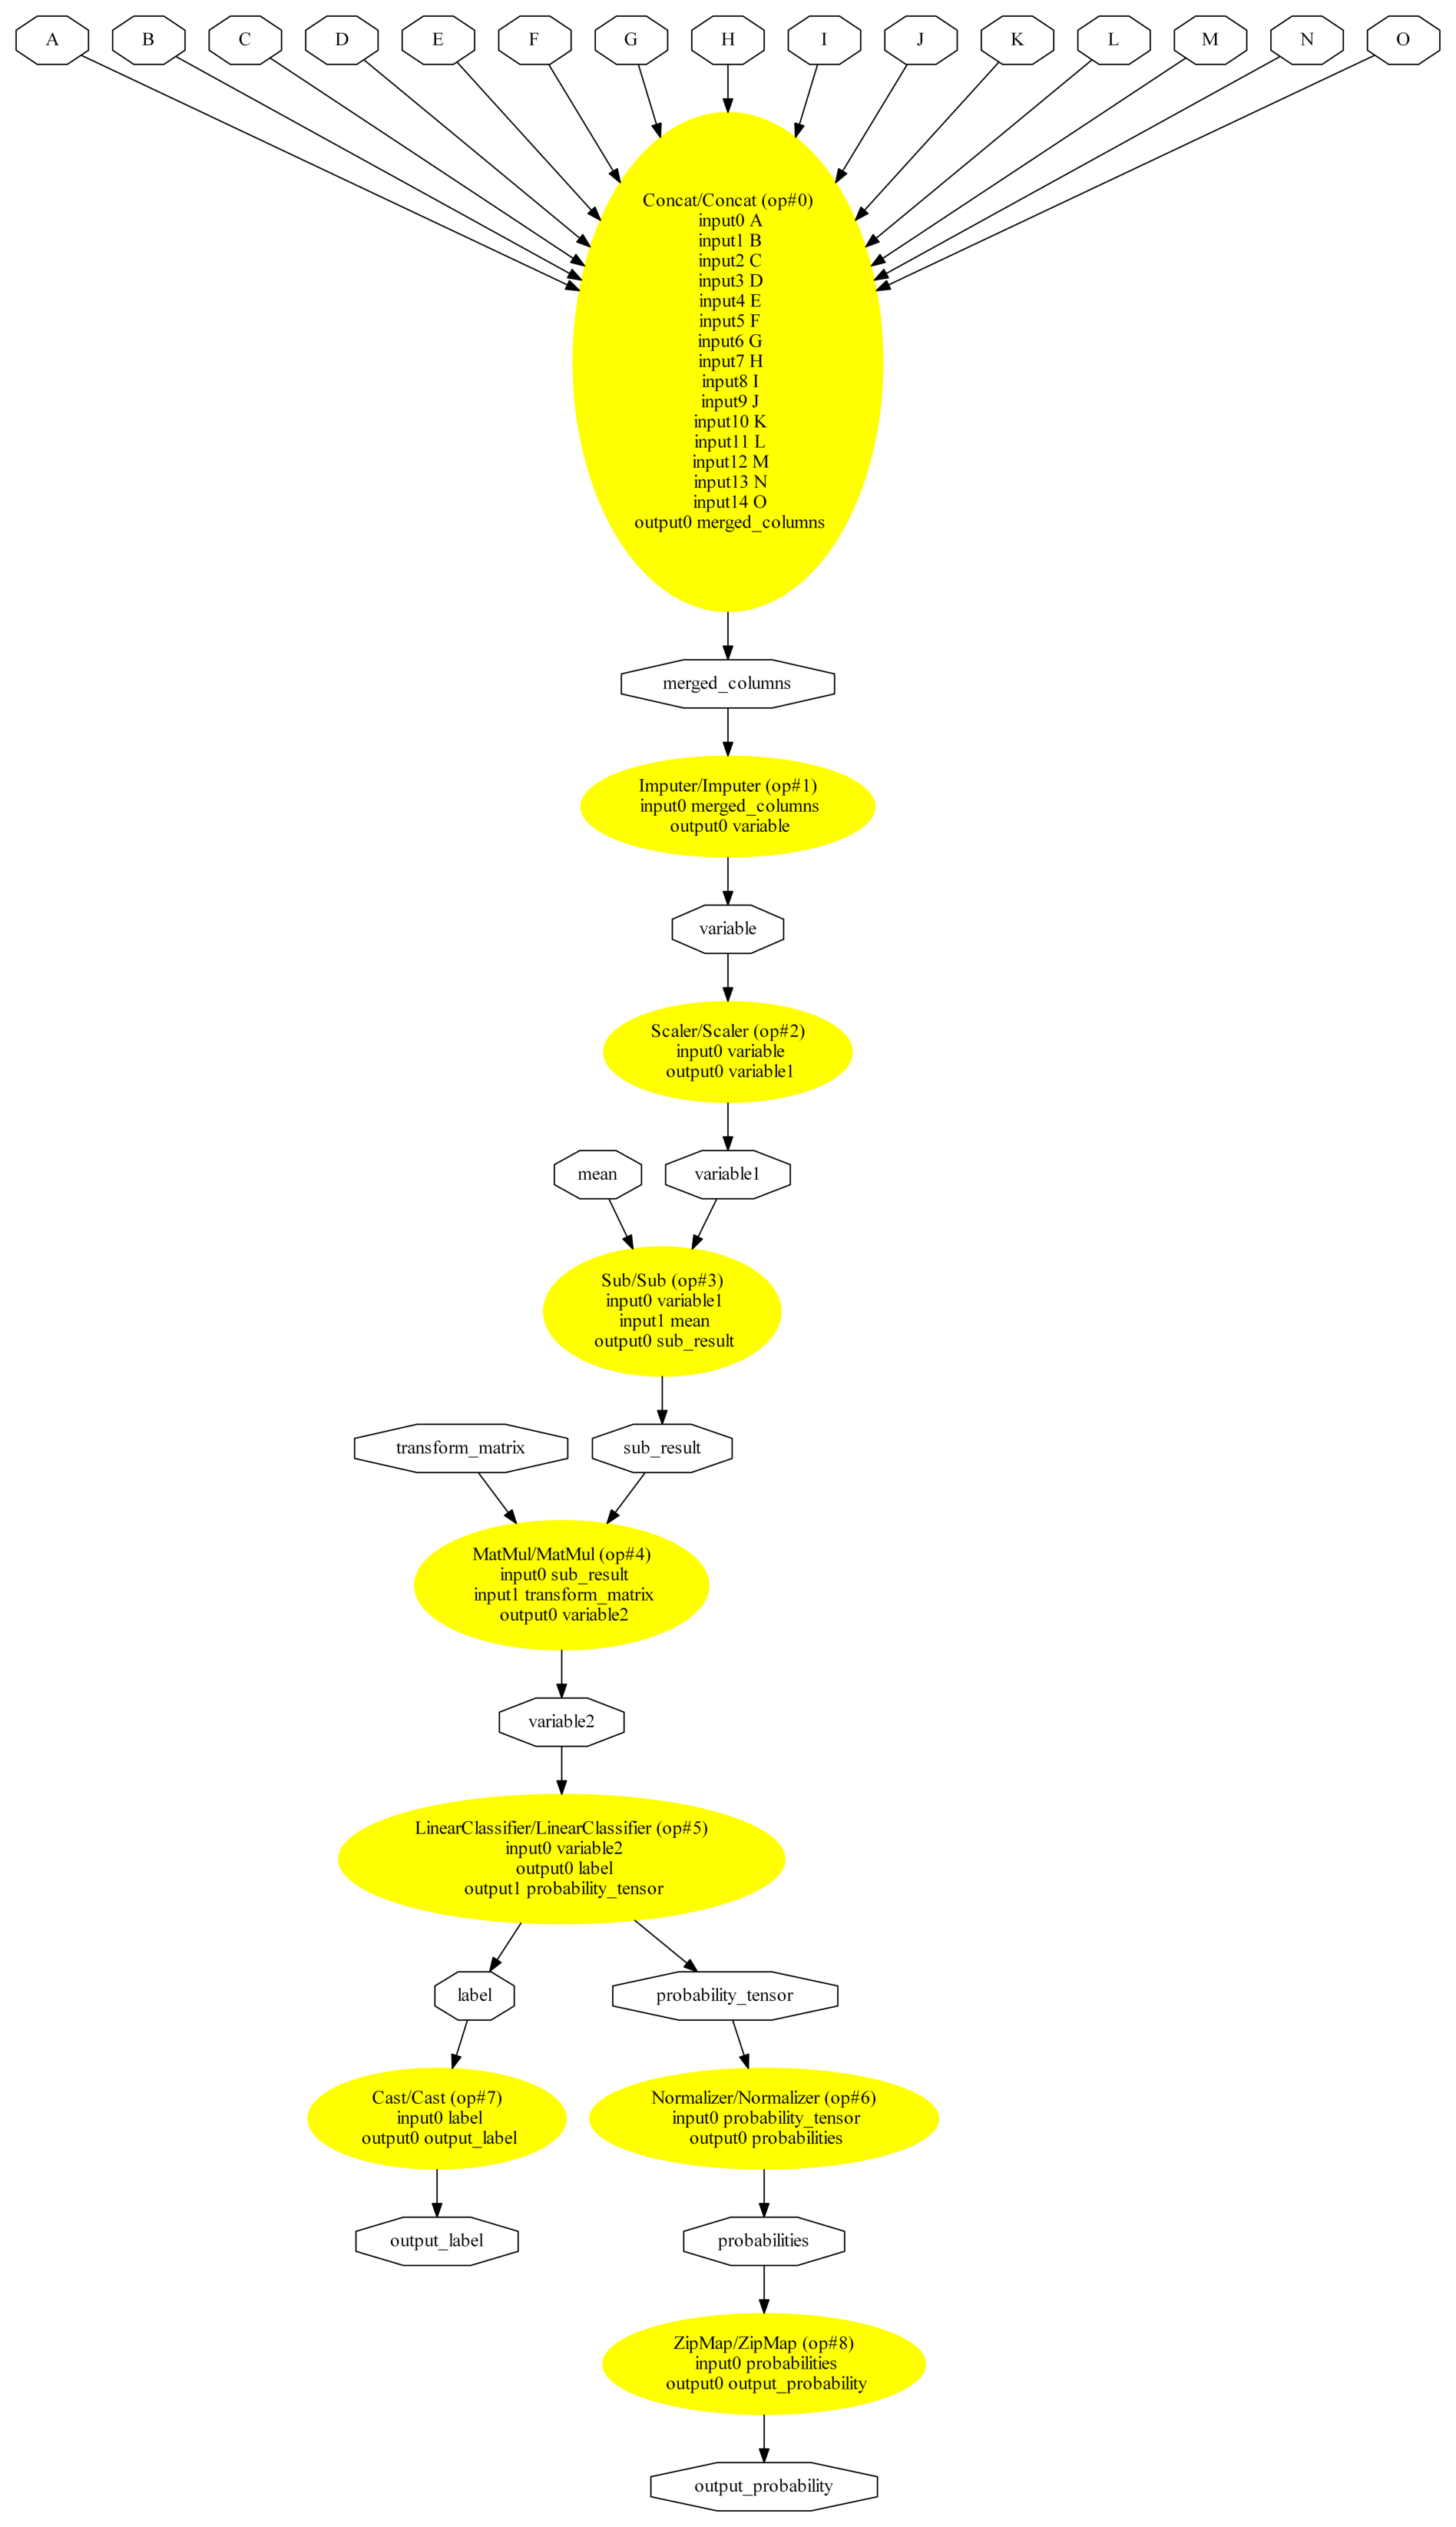

In [53]:
# Run the project
run_app()

## Step 6: Conclusion

- PCA is an efficient data preprocess technique before modeling that could reduce the data dimensinality while most variance are preserved.

- Data standardizing is necessary for data on different scale before feeding into algorithms that involve distance computation. It also speed up algorithms optimized with gradient descent.

- A data pipeline really makes the data science workflow simple, reproducible and efficient.

- Future work might invole in putting the ONNX based model into production.

## References

Tan, P., Steinbach, M. & Kumar, V. 2019. Introduction to data mining (2nd edi.). Pearson Education.

Udacity.com. 2020. Introduction to Machine Learning. Udacity, Inc.